# Imports

In [1]:
import keras
import datasets
import numpy as np
import math
import transformers
import sklearn.metrics
import tensorflow as tf
import tqdm.notebook as tqdm
import sklearn.model_selection
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

2024-10-29 22:57:45.104998: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-29 22:57:45.421058: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-29 22:57:46.290724: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/dron46/anaconda3/envs/tf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_t

In [2]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

if tf.test.is_gpu_available():
    print("GPU is available and will be used for computations.")
else:
    print("GPU is not available or not being used.")

Name: /physical_device:GPU:0   Type: GPU
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available and will be used for computations.


2024-10-29 22:57:52.476112: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-29 22:57:52.480740: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-29 22:57:52.480786: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-29 22:57:52.495526: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-29 22:57:52.496022: I external/local_xla/xla/stream_executor

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except:
        print('e')

# Dataset

Load the dataset (we will be using [go_emotions](https://huggingface.co/datasets/google-research-datasets/go_emotions)). Pretokenize data or make a loader that tokenizes the sentenses as you iterate through the dataset. Implement two datasets: variable and fixed sentence length (in tokens). Don't forget to split the dataset into train and test subsets

In [4]:
dataset = datasets.load_dataset('google-research-datasets/go_emotions', name='raw', split='train')

In [5]:
emotions = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity',
    'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear',
    'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
    'remorse', 'sadness', 'surprise', 'neutral'
]

In [6]:
tokenizer = transformers.AutoTokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

/home/dron46/anaconda3/envs/tf/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
type(tokenizer)

transformers.models.gpt2.tokenization_gpt2_fast.GPT2TokenizerFast

In [8]:
dataset

Dataset({
    features: ['text', 'id', 'author', 'subreddit', 'link_id', 'parent_id', 'created_utc', 'rater_id', 'example_very_unclear', 'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral'],
    num_rows: 211225
})

In [9]:
type(dataset)

datasets.arrow_dataset.Dataset

In [10]:
dataset['text']

['That game hurt.',
 ' >sexuality shouldn’t be a grouping category It makes you different from othet ppl so imo it fits the definition of "grouping" ',
 "You do right, if you don't care then fuck 'em!",
 'Man I love reddit.',
 '[NAME] was nowhere near them, he was by the Falcon. ',
 'Right? Considering it’s such an important document, I should know the damned thing backwards and forwards... thanks again for the help!',
 "He isn't as big, but he's still quite popular. I've heard the same thing about his content. Never watched him much.",
 "That's crazy; I went to a super [RELIGION] high school and I think I can remember 2 girls the entire 4 years that became teen moms.",
 "that's adorable asf",
 '"Sponge Blurb Pubs Quaw Haha GURR ha AAa!" finale is too real',
 "I have, and now that you mention it, I think that's what triggered my nostalgia. ",
 "I wanted to downvote this, but it's not your fault homie.",
 "BUT IT'S HER TURN! /s",
 'That is odd.',
 'Build a wall? /jk',
 "I appreciate it,

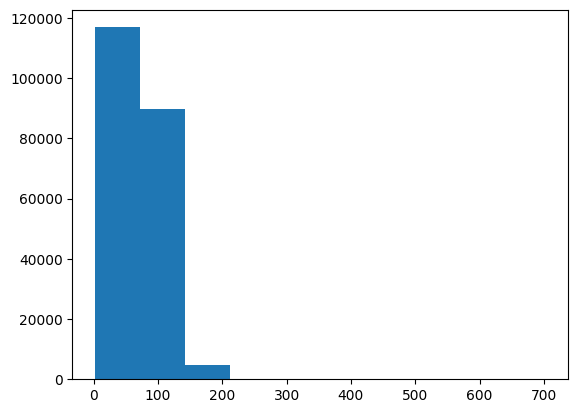

In [11]:
plt.hist([len(x) for x in dataset['text']])
plt.show()

In [12]:
a = np.array([len(x) for x in dataset['text']])

In [13]:
b = a[a != a.max()]
c = b[b != b.max()]
(a.mean(), a.max()), (b.mean(), b.max()), (c.mean(), c.max())

((69.29957154692863, 703), (69.29057105793905, 542), (69.28385703937619, 514))

In [14]:
(a >= 200).sum()

19

In [15]:
np.where(a > 200)

(array([  6591,  13379,  19257,  20825,  28840,  47616,  50647,  54167,
         59642,  90256, 101712, 103896, 109733, 112289, 117137, 155422,
        167928, 172005, 180267]),)

In [16]:
len(dataset['text'])

211225

In [10]:
def filter_long_texts(data):
    return len(data['text']) <= 250


len(dataset.filter(filter_long_texts)['text']), len(dataset.filter(filter_long_texts)['id'])

(211214, 211214)

In [11]:
np.median(list(map(len, tokenizer(dataset.filter(filter_long_texts)['text'])['input_ids']))), np.max(list(map(len, tokenizer(dataset.filter(filter_long_texts)['text'])['input_ids'])))

(17.0, 175)

In [12]:
dataset = dataset.filter(filter_long_texts)

In [13]:
def pretokenize_create_dataset(dataset: type[datasets.arrow_dataset],
                               tokenizer: type[transformers.models.gpt2.tokenization_gpt2_fast],
                               emotions: list[str],
                               shuffle: bool = True,
                               test_size: int = 0.3,
                               batch_size: int = 64,
                               seed: int = 42
):

    
    def tokenize_function(data):
        
        texts = data['text']
        tokenized = tokenizer(texts, truncation=True, padding='max_length', max_length=32, return_tensors='tf')
    
        labels = [data[emotion] for emotion in emotions]
        labels = tf.stack(labels, axis=1)
        
        return {
            'input_ids': tokenized['input_ids'],
            'labels': labels
        }
    
    
    dataset = dataset.map(tokenize_function, batched=True)
    
    columns_to_remove = [col for col in dataset.column_names if col not in ['input_ids', 'labels']]
    tokenized_dataset = dataset.remove_columns(columns_to_remove)
    
    train_test_split = tokenized_dataset.train_test_split(test_size=test_size, shuffle=shuffle, seed=seed)
    train_dataset = train_test_split['train']
    test_dataset = train_test_split['test']

    train_input_ids = train_dataset['input_ids']
    train_labels = train_dataset['labels']
    
    test_input_ids = test_dataset['input_ids']
    test_labels = test_dataset['labels']
    
    train_dataset = tf.data.Dataset.from_tensor_slices((train_input_ids, train_labels))
    test_dataset = tf.data.Dataset.from_tensor_slices((test_input_ids, test_labels))

    train_dataset = train_dataset.batch(batch_size)
    test_dataset = test_dataset.batch(batch_size)
    
    return train_dataset, test_dataset

In [15]:
fixed_train_dataset, fixed_test_dataset = pretokenize_create_dataset(dataset, tokenizer, emotions, shuffle=True, test_size=0.3, batch_size=64, seed=747) #seed=42

2024-10-29 21:05:57.693084: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-29 21:05:57.693243: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-29 21:05:57.693267: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-29 21:05:57.693985: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-29 21:05:57.694016: I tensorflow/core/common_runtime/gpu/gpu

In [16]:
fixed_train_dataset, fixed_test_dataset

(<_BatchDataset element_spec=(TensorSpec(shape=(None, 32), dtype=tf.int32, name=None), TensorSpec(shape=(None, 28), dtype=tf.int32, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, 32), dtype=tf.int32, name=None), TensorSpec(shape=(None, 28), dtype=tf.int32, name=None))>)

In [13]:
class TextSequence(tf.keras.utils.Sequence):
    def __init__(
        self,
        dataset: type[datasets.arrow_dataset],
        batch_size: int = 64,
        shuffle: bool = True,
        split: str = 'train',
        test_size: float = 0.3,
        seed: int = 42,
        tokenizer: type[transformers.models.gpt2.tokenization_gpt2_fast] = None,
        emotions: list[str] = None,
    ):
        
        if split not in {"train", "test"}:
            raise ValueError(
                '`split` must be either "train", "test", 'f"received: {split}"
            )
            
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.emotions = emotions
    
        dataset = dataset.map(self.tokenize_function, batched=True)
        

        tokenized_dataset = dataset.remove_columns([col for col in dataset.column_names if col not in ['input_ids', 'labels']])
        
        train_test_split = tokenized_dataset.train_test_split(test_size=test_size, shuffle=shuffle, seed=seed)
        
        dataset = train_test_split[split]

        self.input_ids = dataset['input_ids']
        self.labels = dataset['labels']
        
    def tokenize_function(self, data):
        
        texts = data['text']
        tokenized = self.tokenizer(texts)
            
        labels = [data[emotion] for emotion in self.emotions]
        labels = tf.stack(labels, axis=1)
        
        return {
            'input_ids': tokenized['input_ids'],
            'labels': labels
        }

    def __len__(self):
        return (len(self.input_ids) + self.batch_size - 1) // self.batch_size
        
    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size

        tokens = self.input_ids[start:end]
        labels = self.labels[start:end]
        
        padded_tokens = tf.keras.preprocessing.sequence.pad_sequences(tokens, padding='post', value=tokenizer.pad_token_id)
        
        return np.array(padded_tokens), np.array(labels)

In [14]:
variable_train_dataset = TextSequence(dataset=dataset, batch_size=64, shuffle=True, split='train', test_size=0.3, seed=747, tokenizer=tokenizer, emotions=emotions)
variable_test_dataset = TextSequence(dataset=dataset, batch_size=64, shuffle=True, split='test', test_size=0.3, seed=747, tokenizer=tokenizer, emotions=emotions)

In [15]:
variable_train_dataset, variable_test_dataset

(<__main__.TextSequence at 0x7f7a3057f130>,
 <__main__.TextSequence at 0x7f7a401f7340>)

In [43]:
len(variable_test_dataset)

991

In [44]:
(len(variable_test_dataset.input_ids) + variable_test_dataset.batch_size - 1) // variable_test_dataset.batch_size

991

In [45]:
(989 + 1) * variable_test_dataset.batch_size

63360

In [46]:
X = iter(variable_train_dataset)

In [47]:
X

In [48]:
next(X)

(array([[   40,  1842,   428, ..., 50256, 50256, 50256],
        [ 1212,  1048,   318, ..., 50256, 50256, 50256],
        [ 2949,  1106,  3919, ..., 50256, 50256, 50256],
        ...,
        [10449,   345,     0, ..., 50256, 50256, 50256],
        [  818,   884,   257, ..., 50256, 50256, 50256],
        [10449,   345,   329, ..., 50256, 50256, 50256]], dtype=int32),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]))

# Model

Implement your model. The model should have the RNN architecture (with LSTM or GRU cells), support stacking and bidirectional feature extraction.

In [16]:
def get_name(prefix: str | None = None, suffix: str | None = None, separator: str = '_') -> str | None:
    return prefix and prefix + separator + suffix or suffix or None

In [17]:
def get_model(
    units: int,
    n_tokens: int,
    n_labels: int,
    n_stacks: int = 1,
    bidirectional: bool = False,
    name: str | None = None,
    cell_type: type[keras.layers.Layer] = keras.layers.LSTMCell
) -> keras.Model:
    '''Creates a model with RNN architecture for sequence multilabel classification.

    Arguments:
        units: dimensionality of RNN cells
        n_tokens: number of tokens in the tokenizer dictionary
        n_labels: number of labels to be predicted
        n_stacks: number of RNN cells in the stack (1 -- no stacking)
        bidirectional: whether or not the model is bidirectional
        name: the model name
        cell_type: type of a cell to use, either keras.layers.LSTMCell or keras.layers.GRUCell

    Returns:
        The model'''
    
    inputs = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name=get_name(name, 'inputs'))
    
    embedding = tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=units, name=get_name(name, 'embedding'))(inputs)

    if bidirectional:
        rnn_layer = tf.keras.layers.Bidirectional(
            tf.keras.layers.RNN(
                [cell_type(units) for _ in range(n_stacks)],
                return_sequences=False,
                name=get_name(name, 'rnn')
            ), name=get_name(name, 'bidirectional')
        )(embedding)
        
    else:
        rnn_layer = tf.keras.layers.RNN(
            [cell_type(units) for _ in range(n_stacks)],
            return_sequences=False,
            name=get_name(name, 'rnn')
        )(embedding)

    outputs = tf.keras.layers.Dense(n_labels, activation='sigmoid', name=get_name(name, 'dense'))(rnn_layer)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name=name)
    
    return model

In [19]:
model = get_model(units=128, n_tokens=tokenizer.vocab_size, n_labels=len(emotions), n_stacks=1, bidirectional=False, name='RNN_Classifier', cell_type=tf.keras.layers.LSTMCell)

model.summary()

Model: "RNN_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ RNN_Classifier_inputs           │ (None, None)           │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ RNN_Classifier_embedding        │ (None, None, 128)      │     6,432,896 │
│ (Embedding)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ RNN_Classifier_rnn (RNN)        │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ RNN_Classifier_dense (Dense)    │ (None, 28)             │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,568,092 (25.06 MB)

 Trainable params: 6,568,092 (25.06 MB)

 Non-trainable params: 0 (0.00 B)

In [70]:
model.layers

[<InputLayer name=LSTM_bidirect_stacked_inputs, built=True>,
 <Embedding name=LSTM_bidirect_stacked_embedding, built=True>,
 <Bidirectional name=LSTM_bidirect_stacked_bidirectional, built=True>,
 <Dense name=LSTM_bidirect_stacked_dense, built=True>]

In [71]:
x, y = next(iter(variable_train_dataset))

In [72]:
x

array([[   40,  1842,   428, ..., 50256, 50256, 50256],
       [ 1212,  1048,   318, ..., 50256, 50256, 50256],
       [ 2949,  1106,  3919, ..., 50256, 50256, 50256],
       ...,
       [10449,   345,     0, ..., 50256, 50256, 50256],
       [  818,   884,   257, ..., 50256, 50256, 50256],
       [10449,   345,   329, ..., 50256, 50256, 50256]], dtype=int32)

In [73]:
model(x)

<tf.Tensor: shape=(64, 28), dtype=float32, numpy=
array([[1.7085786e-01, 3.1861025e-03, 6.0191483e-04, ..., 3.3478567e-04,
        1.7898474e-03, 2.2223817e-02],
       [5.1931303e-02, 2.4411267e-02, 1.2084696e-02, ..., 1.3862886e-02,
        5.2453786e-01, 9.6638270e-02],
       [1.4561161e-02, 5.1570418e-03, 2.6429094e-02, ..., 7.2334385e-03,
        3.5980311e-03, 7.7725001e-02],
       ...,
       [1.3704209e-01, 7.0455712e-03, 8.3236856e-04, ..., 2.2082049e-03,
        4.2557139e-03, 5.0834506e-03],
       [1.9324318e-02, 2.7011952e-03, 6.7396662e-03, ..., 1.0138615e-02,
        2.7039084e-03, 3.9514002e-01],
       [5.5531990e-02, 6.6514936e-04, 1.0292910e-03, ..., 1.3964603e-03,
        1.2180965e-03, 6.1554802e-03]], dtype=float32)>

# Training

Train several models on the two dataset variants. Use either of the cell types (LSTM or GRU)
* Simple RNN (no stacking, one direction)
* Stacked RNN (stacking, one direction)
* Bidirectional RNN (no stacking, bidirectional)
* Stacked Bidirectional RNN (stacking, bidirectional)

In [18]:
params_models = np.array([[128, 'LSTM_simple', False, 1, tf.keras.layers.LSTMCell],
                          [128, 'LSTM_stacked', False, 3, tf.keras.layers.LSTMCell],
                          [128, 'LSTM_bidirect', True, 1, tf.keras.layers.LSTMCell],
                          [128, 'LSTM_bidirect_stacked', True, 3, tf.keras.layers.LSTMCell]])

In [19]:
for param in params_models:
    print(param[4])

<class 'keras.src.layers.rnn.lstm.LSTMCell'>
<class 'keras.src.layers.rnn.lstm.LSTMCell'>
<class 'keras.src.layers.rnn.lstm.LSTMCell'>
<class 'keras.src.layers.rnn.lstm.LSTMCell'>


In [22]:
models = [
    get_model(
        units=param[0],
        n_tokens=tokenizer.vocab_size,
        n_labels=len(emotions),
        name=param[1],
        bidirectional=param[2],
        n_stacks=param[3],
        cell_type=param[4]
    )
    for param in params_models
]

In [20]:
models2 = [
    get_model(
        units=param[0],
        n_tokens=tokenizer.vocab_size,
        n_labels=len(emotions),
        name=param[1],
        bidirectional=param[2],
        n_stacks=param[3],
        cell_type=param[4]
    )
    for param in params_models
]

2024-10-29 23:00:08.213821: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-29 23:00:08.213936: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-29 23:00:08.213960: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-29 23:00:08.214315: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-29 23:00:08.214334: I tensorflow/core/common_runtime/gpu/gpu

In [23]:
models

[<Functional name=LSTM_simple, built=True>,
 <Functional name=LSTM_stacked, built=True>,
 <Functional name=LSTM_bidirect, built=True>,
 <Functional name=LSTM_bidirect_stacked, built=True>]

In [21]:
models2

[<Functional name=LSTM_simple, built=True>,
 <Functional name=LSTM_stacked, built=True>,
 <Functional name=LSTM_bidirect, built=True>,
 <Functional name=LSTM_bidirect_stacked, built=True>]

Which loss should be used to multilabel classification? Which metrics?

In [44]:
class MeanPRAuc(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='mean_pr_auc', **kwargs):
        super(MeanPRAuc, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.pr_auc_metrics = [tf.keras.metrics.AUC(curve='PR') for _ in range(num_classes)]

    def update_state(self, y_true, y_pred, sample_weight):
        for i in range(self.num_classes):
            self.pr_auc_metrics[i].update_state(y_true[:, i], y_pred[:, i], sample_weight=sample_weight)

    def result(self):
        return tf.reduce_mean([pr_auc.result() for pr_auc in self.pr_auc_metrics])

    def reset_states(self):
        for pr_auc in self.pr_auc_metrics:
            pr_auc.reset_states()

In [45]:
class MeanRocAuc(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='mean_roc_auc', **kwargs):
        super(MeanRocAuc, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.auc_metrics = [tf.keras.metrics.AUC() for _ in range(num_classes)]

    def update_state(self, y_true, y_pred, sample_weight):
        for i in range(self.num_classes):
            self.auc_metrics[i].update_state(y_true[:, i], y_pred[:, i], sample_weight=sample_weight)

    def result(self):
        return tf.reduce_mean([auc.result() for auc in self.auc_metrics])

    def reset_states(self):
        for auc in self.auc_metrics:
            auc.reset_states()

In [ ]:
checkpoint_path_fixed = "best_weights.hdf5"

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_mean_roc_auc',  
    save_best_only=True,  
    mode='max', 
    verbose=1
)

In [29]:
for model in models:
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        optimizer=keras.optimizers.Adam(),
        metrics=[MeanRocAuc(num_classes=len(emotions)), MeanPRAuc(num_classes=len(emotions))]
    )

In [30]:
models[0].name

'LSTM_simple'

In [31]:
print('Fixed dataset')
for model in models:
    print('-'*30)
    print(f'model training: {model.name}')
    model.fit(fixed_train_dataset, validation_data=fixed_test_dataset, batch_size=64, epochs=10)

Fixed dataset
------------------------------
model training: LSTM_simple
Epoch 1/10
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - loss: 0.1573 - mean_pr_auc: 0.0436 - mean_roc_auc: 0.5049 - val_loss: 0.1480 - val_mean_pr_auc: 0.0931 - val_mean_roc_auc: 0.6374
Epoch 2/10
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - loss: 0.1399 - mean_pr_auc: 0.1340 - mean_roc_auc: 0.6903 - val_loss: 0.1258 - val_mean_pr_auc: 0.2261 - val_mean_roc_auc: 0.7961
Epoch 3/10
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - loss: 0.1213 - mean_pr_auc: 0.2469 - mean_roc_auc: 0.8128 - val_loss: 0.1214 - val_mean_pr_auc: 0.2666 - val_mean_roc_auc: 0.8208
Epoch 4/10
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - loss: 0.1125 - mean_pr_auc: 0.3093 - mean_roc_auc: 0.8539 - val_loss: 0.1214 - val_mean_pr_auc: 0.2763 - val_mean_roc_auc: 0.8252
Epoch 5/10
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 0.1060 - mean_pr_auc: 0.3547 - mean_roc_auc: 0.8794 - val_loss: 0.1233 - val_mean_pr_auc: 0.2775 - val_mean_roc

In [32]:
for i, model in enumerate(models):
    print('-'*30)
    model.save_weights(f'new_wights/fixed_{model.name}.weights.h5')
    print(f'Веса модели {model.name} сохранены')

------------------------------
Веса модели LSTM_simple сохранены
------------------------------
Веса модели LSTM_stacked сохранены
------------------------------
Веса модели LSTM_bidirect сохранены
------------------------------
Веса модели LSTM_bidirect_stacked сохранены


In [24]:
for model in models2:
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        optimizer=keras.optimizers.Adam(),
        metrics=[MeanRocAuc(num_classes=len(emotions)), MeanPRAuc(num_classes=len(emotions))]
    )

каждая модель обучалась на 10 эпохах

In [34]:
# обучалась по 5  эпох
print('Variable dataset')
print('The first model')
print(f'model training: {models2[0].name}')
models2[0].fit(variable_train_dataset, validation_data=variable_test_dataset, batch_size=64, epochs=5)

Variable dataset
The first model
model training: LSTM_simple
Epoch 1/5
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - loss: 0.1427 - mean_pr_auc: 0.1209 - mean_roc_auc: 0.6689 - val_loss: 0.1270 - val_mean_pr_auc: 0.2164 - val_mean_roc_auc: 0.7828
Epoch 2/5
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 0.1214 - mean_pr_auc: 0.2419 - mean_roc_auc: 0.8132 - val_loss: 0.1219 - val_mean_pr_auc: 0.2576 - val_mean_roc_auc: 0.8149
Epoch 3/5
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 0.1127 - mean_pr_auc: 0.3045 - mean_roc_auc: 0.8547 - val_loss: 0.1204 - val_mean_pr_auc: 0.2767 - val_mean_roc_auc: 0.8244
Epoch 4/5
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - loss: 0.1058 - mean_pr_auc: 0.3534 - mean_roc_auc: 0.8780 - val_loss: 0.1211 - val_mean_pr_auc: 0.2819 - val_mean_roc_auc: 0.8250
Epoch 5/5
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 0.1009 - mean_pr_auc: 0.3867 - mean_roc_auc: 0.8951 - val_loss: 0.1222 - val_mean_pr_auc: 0.2824 - val_mean_roc_auc: 0.8251


In [35]:
models2[0].save_weights(f'new_wights/variable_{models2[0].name}.weights.h5')
print(f'Веса модели {models2[0].name} сохранены')

Веса модели LSTM_simple сохранены


In [32]:
print('Variable dataset')
print('second model')
print(f'model training: {models2[1].name}')
models2[1].fit(variable_train_dataset, validation_data=variable_test_dataset, batch_size=64, epochs=10)

Variable dataset
second model
model training: LSTM_stacked
Epoch 1/10


/home/dron46/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1730203835.844996   41772 service.cc:145] XLA service 0xfedbe80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730203835.845043   41772 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-10-29 22:10:36.178789: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-29 22:10:36.960728: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


   1/2311 ━━━━━━━━━━━━━━━━━━━━ 7:39:23 12s/step - loss: 0.6944 - mean_pr_auc: 0.0451 - mean_roc_auc: 0.3834

I0000 00:00:1730203841.097647   41772 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2311/2311 ━━━━━━━━━━━━━━━━━━━━ 329s 137ms/step - loss: 0.1690 - mean_pr_auc: 0.0422 - mean_roc_auc: 0.4994 - val_loss: 0.1574 - val_mean_pr_auc: 0.0422 - val_mean_roc_auc: 0.5000
Epoch 2/10
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 37s 16ms/step - loss: 0.1573 - mean_pr_auc: 0.0420 - mean_roc_auc: 0.4986 - val_loss: 0.1572 - val_mean_pr_auc: 0.0422 - val_mean_roc_auc: 0.5000
Epoch 3/10
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 36s 16ms/step - loss: 0.1580 - mean_pr_auc: 0.0420 - mean_roc_auc: 0.4968 - val_loss: 0.1573 - val_mean_pr_auc: 0.0423 - val_mean_roc_auc: 0.5001
Epoch 4/10
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 34s 15ms/step - loss: 0.1553 - mean_pr_auc: 0.0558 - mean_roc_auc: 0.5428 - val_loss: 0.1398 - val_mean_pr_auc: 0.1283 - val_mean_roc_auc: 0.7028
Epoch 5/10
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 34s 15ms/step - loss: 0.1362 - mean_pr_auc: 0.1454 - mean_roc_auc: 0.7301 - val_loss: 0.1277 - val_mean_pr_auc: 0.2078 - val_mean_roc_auc: 0.7871
Epoch 6/10
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 34s 15ms/step - loss: 0.122

In [33]:
models2[1].save_weights(f'new_wights/variable_{models2[1].name}.weights.h5')
print(f'Веса модели {models2[1].name} сохранены')

Веса модели LSTM_stacked сохранены


In [28]:
print('Variable dataset')
print('third model')
print(f'model training: {models2[2].name}')
models2[2].fit(variable_train_dataset, validation_data=variable_test_dataset, batch_size=64, epochs=10)

Variable dataset
third model
model training: LSTM_bidirect
Epoch 1/10


/home/dron46/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1730204943.833310   48408 service.cc:145] XLA service 0x1553a4c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730204943.833351   48408 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-10-29 22:29:04.146449: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-29 22:29:04.847504: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907

   1/2311 ━━━━━━━━━━━━━━━━━━━━ 7:20:42 11s/step - loss: 0.6920 - mean_pr_auc: 0.0368 - mean_roc_auc: 0.3198

I0000 00:00:1730204948.942066   48408 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2311/2311 ━━━━━━━━━━━━━━━━━━━━ 323s 135ms/step - loss: 0.1625 - mean_pr_auc: 0.0786 - mean_roc_auc: 0.5896 - val_loss: 0.1278 - val_mean_pr_auc: 0.2142 - val_mean_roc_auc: 0.7880
Epoch 2/10
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 35s 15ms/step - loss: 0.1219 - mean_pr_auc: 0.2401 - mean_roc_auc: 0.8124 - val_loss: 0.1195 - val_mean_pr_auc: 0.2692 - val_mean_roc_auc: 0.8277
Epoch 3/10
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 36s 16ms/step - loss: 0.1118 - mean_pr_auc: 0.3126 - mean_roc_auc: 0.8585 - val_loss: 0.1182 - val_mean_pr_auc: 0.2864 - val_mean_roc_auc: 0.8348
Epoch 4/10
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 39s 17ms/step - loss: 0.1050 - mean_pr_auc: 0.3598 - mean_roc_auc: 0.8831 - val_loss: 0.1192 - val_mean_pr_auc: 0.2901 - val_mean_roc_auc: 0.8344
Epoch 5/10
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 40s 17ms/step - loss: 0.0998 - mean_pr_auc: 0.3993 - mean_roc_auc: 0.9012 - val_loss: 0.1202 - val_mean_pr_auc: 0.2912 - val_mean_roc_auc: 0.8355
Epoch 6/10
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 37s 16ms/step - loss: 0.095

In [29]:
models2[2].save_weights(f'new_wights/variable_{models2[2].name}.weights.h5')
print(f'Веса модели {models2[2].name} сохранены')

Веса модели LSTM_bidirect сохранены


In [25]:
print('Variable dataset')
print('fourth model')
print(f'model training: {models2[3].name}')
models2[3].fit(variable_train_dataset, validation_data=variable_test_dataset, batch_size=64, epochs=10)

Variable dataset
fourth model
model training: LSTM_bidirect_stacked
Epoch 1/10


/home/dron46/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1730205741.017939   53649 service.cc:145] XLA service 0x1129afb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730205741.018016   53649 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-10-29 22:42:21.402555: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-29 22:42:22.401583: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907

   1/2311 ━━━━━━━━━━━━━━━━━━━━ 9:05:27 14s/step - loss: 0.6939 - mean_pr_auc: 0.0452 - mean_roc_auc: 0.4271

I0000 00:00:1730205747.202750   53649 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2311/2311 ━━━━━━━━━━━━━━━━━━━━ 388s 162ms/step - loss: 0.1650 - mean_pr_auc: 0.0527 - mean_roc_auc: 0.5315 - val_loss: 0.1379 - val_mean_pr_auc: 0.1436 - val_mean_roc_auc: 0.7292
Epoch 2/10
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 55s 24ms/step - loss: 0.1341 - mean_pr_auc: 0.1546 - mean_roc_auc: 0.7456 - val_loss: 0.1286 - val_mean_pr_auc: 0.2016 - val_mean_roc_auc: 0.7816
Epoch 3/10
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 52s 22ms/step - loss: 0.1238 - mean_pr_auc: 0.2173 - mean_roc_auc: 0.8026 - val_loss: 0.1234 - val_mean_pr_auc: 0.2342 - val_mean_roc_auc: 0.8089
Epoch 4/10
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 52s 23ms/step - loss: 0.1170 - mean_pr_auc: 0.2614 - mean_roc_auc: 0.8367 - val_loss: 0.1220 - val_mean_pr_auc: 0.2558 - val_mean_roc_auc: 0.8205
Epoch 5/10
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 57s 25ms/step - loss: 0.1114 - mean_pr_auc: 0.3056 - mean_roc_auc: 0.8579 - val_loss: 0.1209 - val_mean_pr_auc: 0.2709 - val_mean_roc_auc: 0.8263
Epoch 6/10
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 56s 24ms/step - loss: 0.106

In [27]:
models2[3].save_weights(f'new_wights/variable_{models2[3].name}.weights.h5')
print(f'Веса модели {models2[3].name} сохранены')

Веса модели LSTM_bidirect_stacked сохранены


# Evaluation

Evaluate the models you trained on the test datasets. Plot ROC curves for each label (use `sklearn.metrics.RocCurveDisplay`) for each model.

In [33]:
def plot_roc_curves(
    X_test: np.ndarray,
    y_test: np.ndarray,
    model: keras.Model,
    num_classes: int,
    model_name: str,
    ax: plt.Axes | None = None
) -> None:
    
    y_pred = model.predict(X_test)
    
    roc_auc_scores = []
    
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        roc_auc_scores.append(roc_auc)
        
        display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=f'Class {emotions[i]}')
        display.plot(ax=ax, name=f'Class {emotions[i]}', color=plt.cm.gist_rainbow(i/num_classes)) #color=plt.cm.tab10(i)

    mean_roc_auc = np.mean(roc_auc_scores)
    ax.set_title(f'ROC Curves for {model_name}; Mean ROC_AUC: {mean_roc_auc}')
    ax.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
    ax.legend(loc='lower right')

    return mean_roc_auc

Fixed_dataset

In [26]:
for i, model in enumerate(models):
    print('-'*30)
    model.load_weights(f'new_wights/fixed_{model.name}.weights.h5')
    print(f'Веса модели {model.name} загружены')

------------------------------
Веса модели LSTM_simple загружены
------------------------------
Веса модели LSTM_stacked загружены
------------------------------
Веса модели LSTM_bidirect загружены
------------------------------
Веса модели LSTM_bidirect_stacked загружены


2024-10-29 21:43:36.332986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1981/1981 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
1981/1981 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
1981/1981 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
1981/1981 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


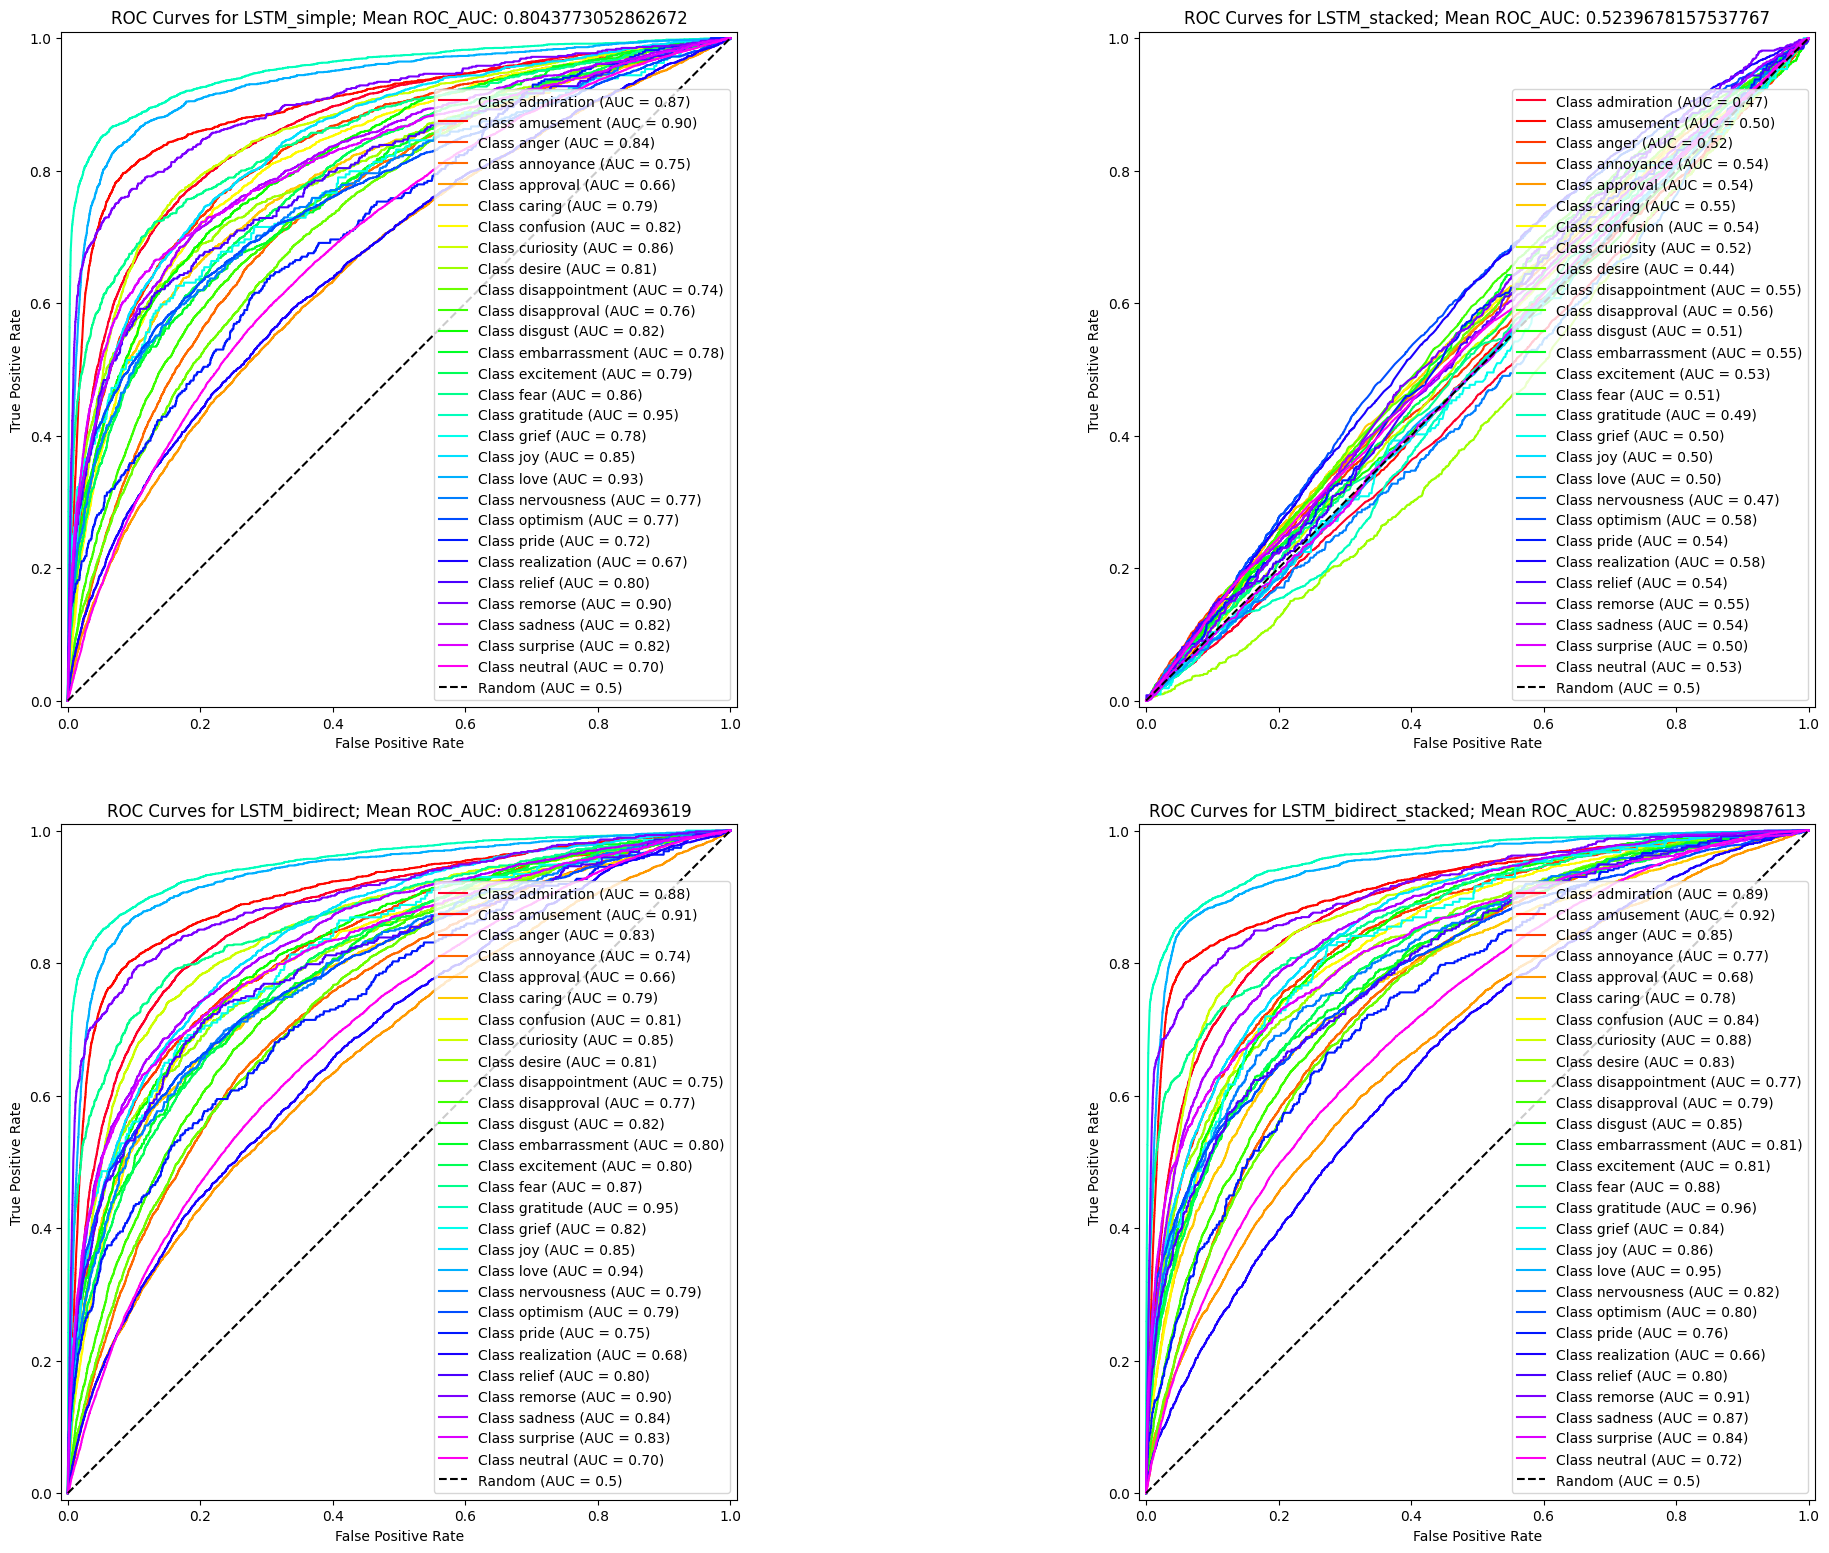

In [34]:
X_test_list = []
y_test_list = []

for batch in fixed_test_dataset:
    X_batch, y_batch = batch
    X_test_list.append(X_batch.numpy())
    y_test_list.append(y_batch.numpy())

X_test = np.concatenate(X_test_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)

_, axes = plt.subplots(2, 2, figsize=(24, 16))

mean_roc_auc_list = []
for i, model in enumerate(models):
    ax = axes[i // 2, i % 2]
    mean_roc_auc = plot_roc_curves(X_test, y_test, model, 28, model.name, ax=ax)
    mean_roc_auc_list.append(mean_roc_auc)
plt.tight_layout()
plt.show()

In [35]:
for i, roc_auc in enumerate(mean_roc_auc_list):
    print(f"Среднее значение ROC_AUC для модели: {models[i].name}")
    print(f'{np.round(roc_auc, 5) * 100}%')
    print()

Среднее значение ROC_AUC для модели: LSTM_simple
80.438%

Среднее значение ROC_AUC для модели: LSTM_stacked
52.397000000000006%

Среднее значение ROC_AUC для модели: LSTM_bidirect
81.281%

Среднее значение ROC_AUC для модели: LSTM_bidirect_stacked
82.596%



Variable_dataset

In [22]:
for i, model in enumerate(models2):
    print('-'*30)
    model.load_weights(f'new_wights/variable_{model.name}.weights.h5')
    print(f'Веса модели {model.name} загружены')

------------------------------
Веса модели LSTM_simple загружены
------------------------------
Веса модели LSTM_stacked загружены
------------------------------
Веса модели LSTM_bidirect загружены
------------------------------
Веса модели LSTM_bidirect_stacked загружены


In [23]:
def plot_roc_curves_2(
    test_dataset: tf.keras.utils.Sequence,
    model: keras.Model,
    num_classes: int,
    model_name: str,
    ax: plt.Axes | None = None
) -> None:
    
    y_pred_list = []
    y_true_list = []
    # batch_count = 0
    i = 0
    for batch in test_dataset:
        i += 1
        X_batch, y_batch = batch
        # print(f"batch {batch_count}: X_batch.shape={X_batch.shape}, y_batch.shape={y_batch.shape}")
        if X_batch.size == 0 or y_batch.size == 0:
            break  
        y_pred_batch = model.predict(X_batch, verbose=0)
        y_pred_list.append(y_pred_batch)
        y_true_list.append(y_batch)
        # batch_count += 1
        if i == 991:
            break
        
    y_pred = np.concatenate(y_pred_list, axis=0)
    y_true = np.concatenate(y_true_list, axis=0)
    
    roc_auc_scores = []

    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        roc_auc_scores.append(roc_auc)
        
        display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=f'Class {emotions[i]}')
        display.plot(ax=ax, name=f'Class {emotions[i]}', color=plt.cm.gist_rainbow(i/num_classes))

    mean_roc_auc = np.mean(roc_auc_scores)
    ax.set_title(f'ROC Curves for {model_name}; Mean ROC_AUC: {mean_roc_auc}')
    ax.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
    ax.legend(loc='lower right')

    return mean_roc_auc

In [43]:
x = iter(variable_test_dataset)

In [46]:
len(variable_test_dataset)

991

I0000 00:00:1730206888.628382   60460 service.cc:145] XLA service 0x11f3f310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730206888.628421   60460 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-10-29 23:01:28.639109: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-29 23:01:28.708346: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1730206888.990391   60460 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


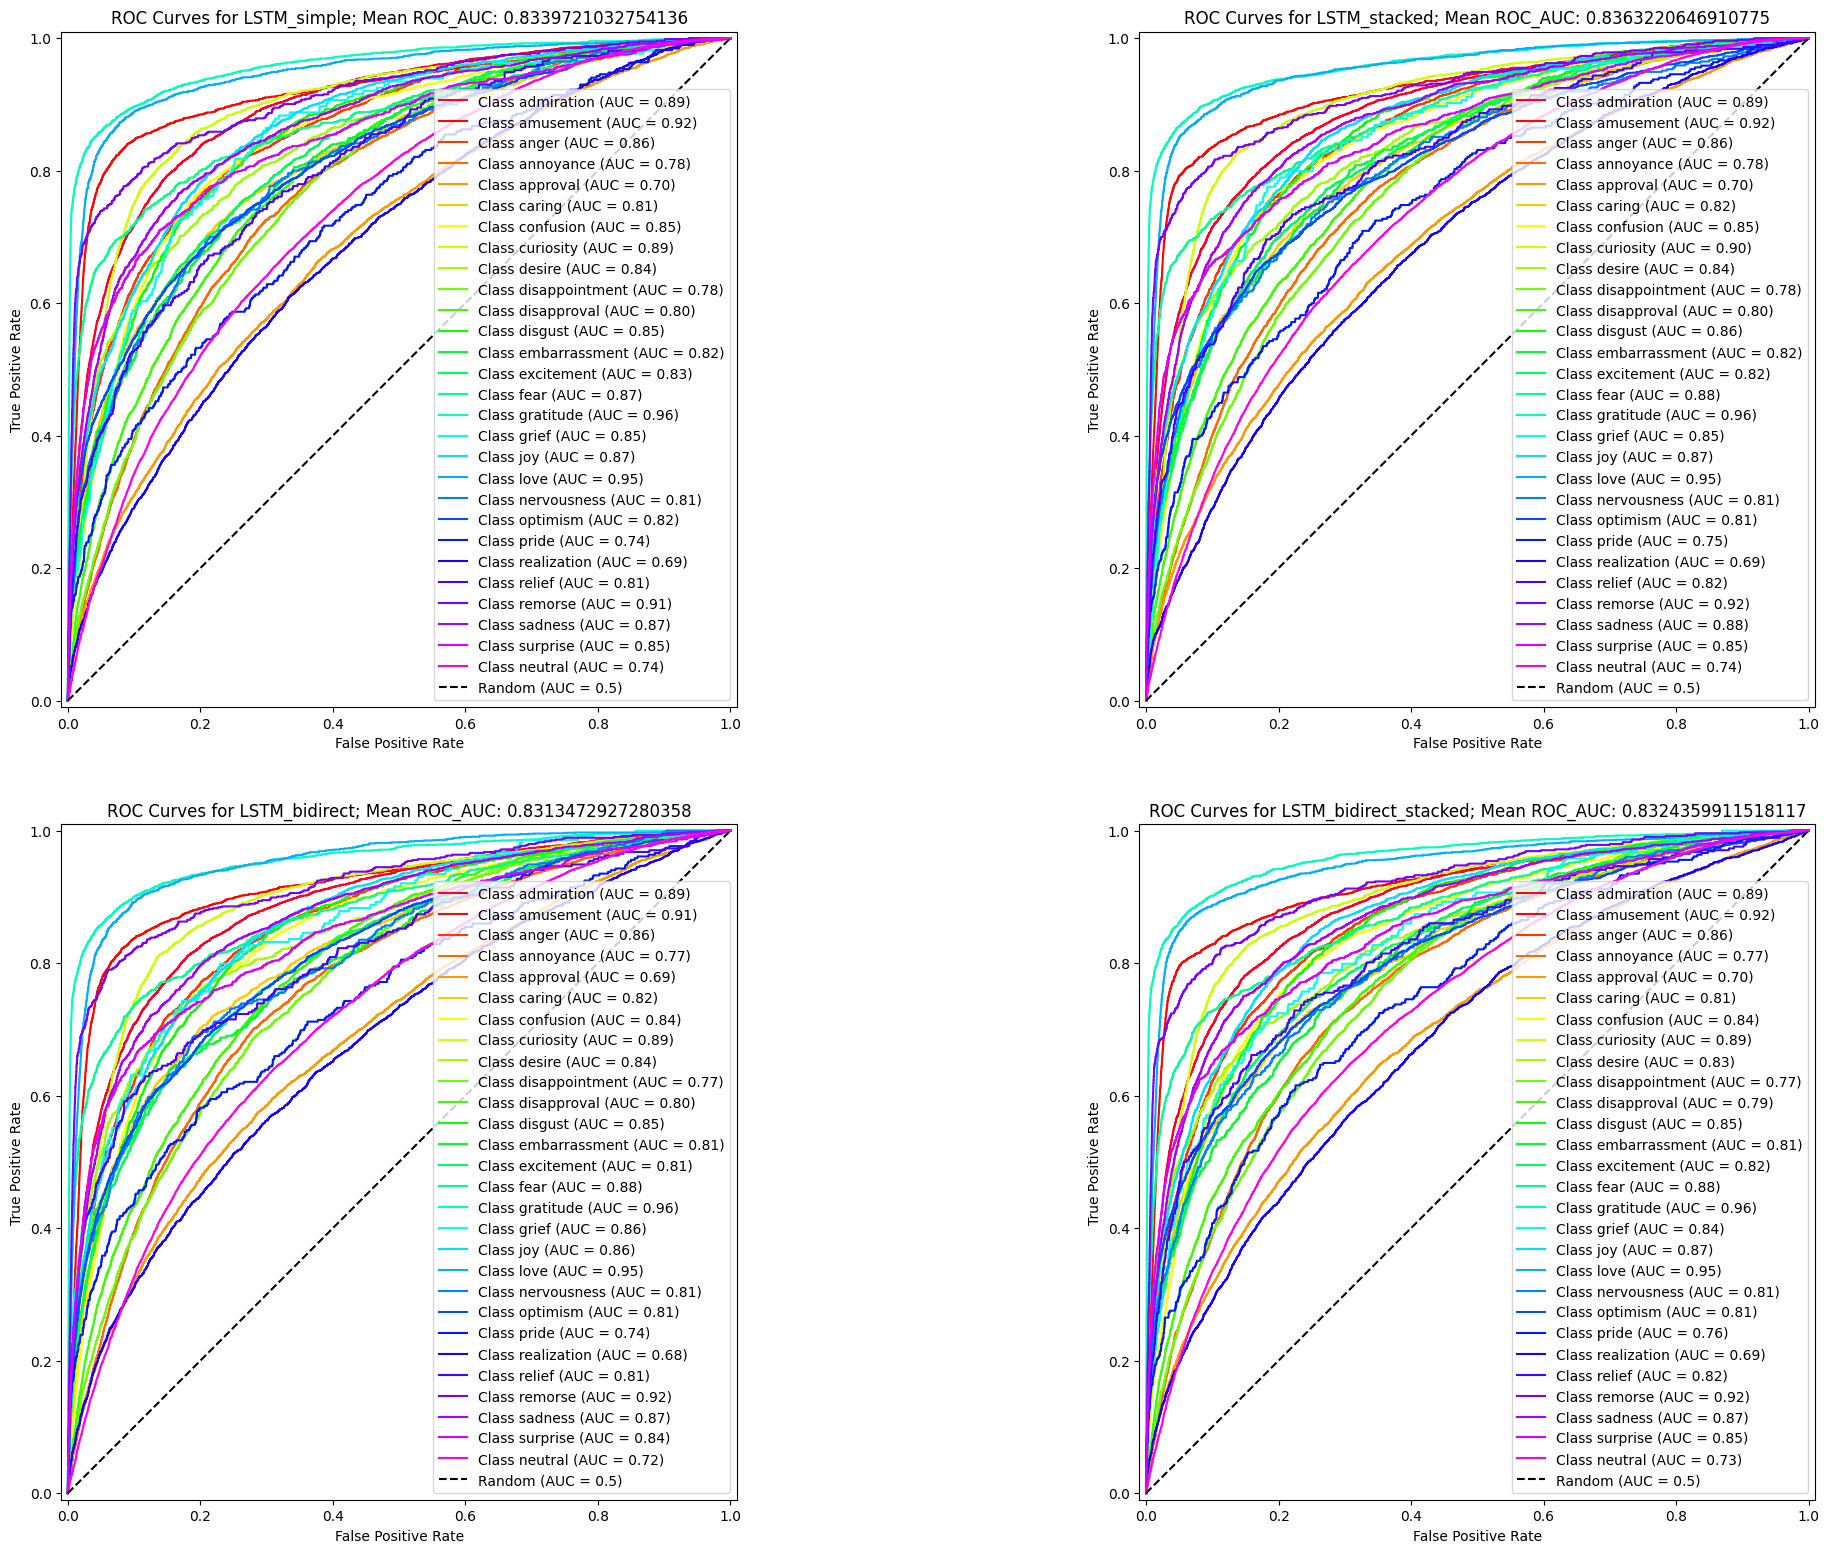

In [24]:
_, axes = plt.subplots(2, 2, figsize=(24, 16))

mean_roc_auc_list2 = []
for i, model in enumerate(models2):
    ax = axes[i // 2, i % 2]
    mean_roc_auc = plot_roc_curves_2(variable_test_dataset, model, 28, model.name, ax=ax)
    mean_roc_auc_list2.append(mean_roc_auc)

plt.tight_layout()
plt.show()

In [25]:
for i, roc_auc in enumerate(mean_roc_auc_list2):
    print(f"Среднее значение ROC_AUC для модели: {models2[i].name}")
    print(f'{np.round(roc_auc, 5) * 100}%')
    print()

Среднее значение ROC_AUC для модели: LSTM_simple
83.397%

Среднее значение ROC_AUC для модели: LSTM_stacked
83.63199999999999%

Среднее значение ROC_AUC для модели: LSTM_bidirect
83.135%

Среднее значение ROC_AUC для модели: LSTM_bidirect_stacked
83.244%



Plot the mean ROC AUC scores. Which model has the highest score? On what kind of dataset?

Inspect the best model performance closer. Come up with some sentences (in English). Does the model output sensible results?

In [26]:
def label_text(text: str, model: keras.Model, threshold: float = 0.5, max_length: int | None = None) -> list[str]:
    '''Computes the model output for `text` and outputs a list of emotions that have a probability of at least `threshold`

    Arguments:
        text: text to label
        model: model to use
        threshold: threshold to use
        max_length: max length for tokenization
    
    Return:
        List of predicted emotion labels'''

    token_text = tokenizer(text, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')['input_ids']
    pred_prob = np.argwhere(model.predict(token_text)[0] >= threshold)
    if pred_prob.size == 0:
        return "Не удалось определить эмоцию по данному трешхолду"
        
    return [emotions[p] for p in np.concatenate(pred_prob)]

In [27]:
def plot_emotion_scores(text: str, model: keras.Model, max_length: int | None = None, ax: plt.Axes | None = None):
    '''Plots a bar plot of emotion probabilities for given `text` using `model`.

    Arguments:
        text: text to label
        model: model to use        
        max_length: max length for tokenization
        ax: axes to plot on'''
    
    token_text = tokenizer(text, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')['input_ids']
    pred_prob = model.predict(token_text, verbose=0)[0]
    ax.bar(emotions, pred_prob)
    ax.set_xticks(range(len(emotions)))
    ax.set_title(f'Text: "{text}"')
    ax.set_xticklabels(emotions, rotation=45)
    

For each of your texts get a list of emotion labels and plot emotion scores

Fixed model

In [38]:
best_fixed_model = models[2]
print(f'best_model: {best_fixed_model.name}')

best_model: LSTM_bidirect


In [39]:
text1 = 'I loved this food so much!'
text2 = "I loved this food so much! It's so sad to leave here"
emothion_labels = label_text(text1, best_fixed_model, threshold=0.5, max_length=32)
print(f'for text1: {emothion_labels}')
emothion_labels1 = label_text(text1, best_fixed_model, threshold=0.1, max_length=32)
print(f'for text1 with threshold 0.1: {emothion_labels1}')
emothion_labels2 = label_text(text2, best_fixed_model, threshold=0.5, max_length=32)
print(f'for text2: {emothion_labels2}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
for text1: ['love']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
for text1 with threshold 0.1: ['love']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
for text2: ['love', 'sadness']


In [40]:
phrases = [
    "Today I feel incredibly happy!", #"happiness"
    "I'm so glad to finally see my family after a long absence.", #"happiness"
    "This day was simply magical, and I can't contain my excitement!", #"happiness"
    "Today I feel very sad after losing my beloved pet.", #"sadness"
    "It seems like the world is crashing down on me, and I don't know how to cope.", #"sadness"
    "This day was filled with sorrow and loneliness.", #"sadness"
    "I'm so angry at this person for what they did!", #"anger"
    "This is unfair, and I can't hold back my anger!", #"anger"
    "I feel like my blood is boiling when I think about this.", #"anger"
    "Today I feel very frightened after hearing these news.", #"fear"
    "It seems like the darkness around me is filled with horror.", #"fear"
    "I'm afraid that my fears are coming true, and I don't know how to deal with it.", #"fear"
    "I was so surprised when I heard this news!", #"surprise"
    "This twist of events left me stunned.", #"surprise"
    "I couldn't believe my eyes when I saw this!", #"surprise"
    "Today I feel quite normal.", #"neutral"
    "This day went by as usual, without any strong emotions.", #"neutral"
    "I'm just going about my business, not feeling anything special.", #"neutral"
]


In [41]:
len(phrases)

18

In [42]:
test_text = "I'm so angry at this person for what they did!"
print(test_text)
emothion_labels = label_text(test_text, best_fixed_model, threshold=0.4, max_length=32)
print(emothion_labels)
print()
test_text = "I feel like my blood is boiling when I think about this."
print(test_text)
emothion_labels = label_text(test_text, best_fixed_model, threshold=0.4, max_length=32)
print(emothion_labels)


I'm so angry at this person for what they did!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
['anger']

I feel like my blood is boiling when I think about this.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
['neutral']


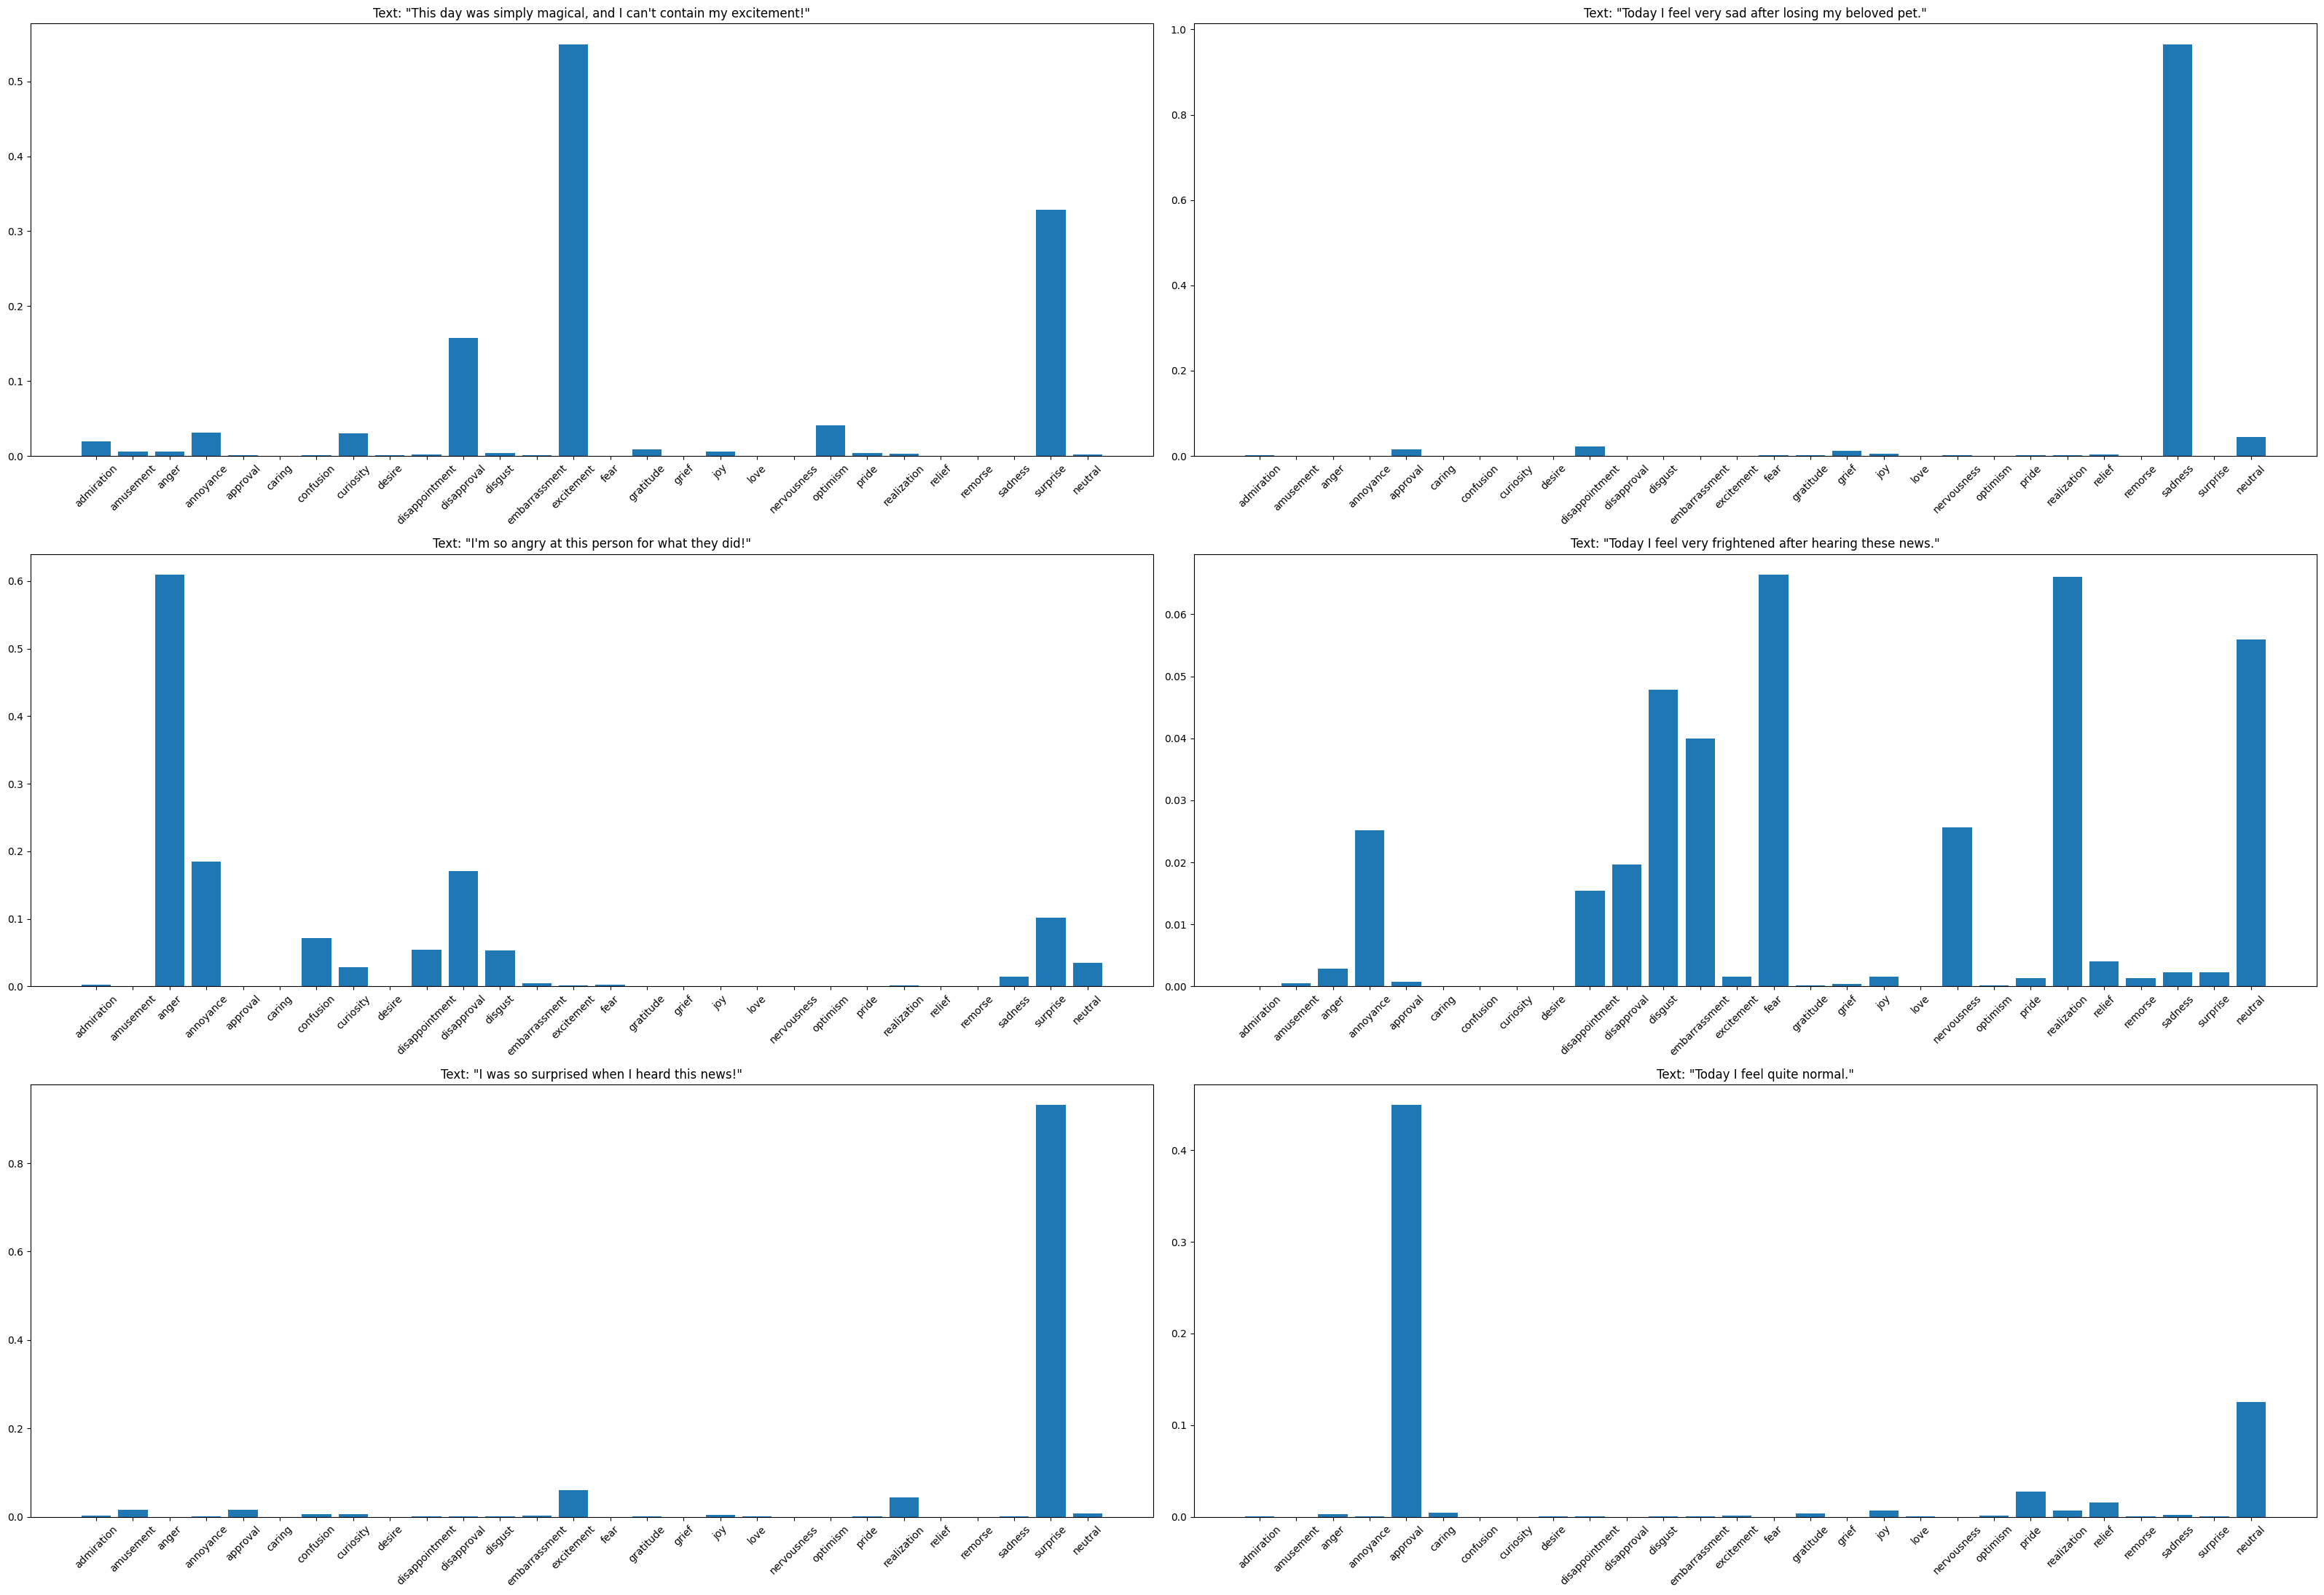

In [43]:
phrases_low = [
    "This day was simply magical, and I can't contain my excitement!", #"happiness"
    "Today I feel very sad after losing my beloved pet.", #"sadness"
    "I'm so angry at this person for what they did!", #"anger"
    "Today I feel very frightened after hearing these news.", #"fear"
    "I was so surprised when I heard this news!", #"surprise"
    "Today I feel quite normal.", #"neutral"
]

_, axes = plt.subplots(3, 2, figsize=(32, 22))

for i, text in enumerate(phrases_low):
    ax = axes[i // 2, i % 2]
    plot_emotion_scores(text, best_fixed_model, max_length=32, ax=ax)
    
plt.tight_layout()
plt.show()

Variable model

In [33]:
best_variable_model = models2[1]
print(f'best_model: {best_variable_model.name}')

best_model: LSTM_stacked


In [34]:
text1 = 'I loved this food so much!'
text2 = "I loved this food so much! It's so sad to leave here"
emothion_labels = label_text(text1, best_variable_model, threshold=0.5, max_length=None)
print(f'for text1: {emothion_labels}')
emothion_labels1 = label_text(text1, best_variable_model, threshold=0.1, max_length=None)
print(f'for text1 with threshold 0.1: {emothion_labels1}')
emothion_labels2 = label_text(text2, best_variable_model, threshold=0.5, max_length=None)
print(f'for text2: {emothion_labels2}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
for text1: ['love']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
for text1 with threshold 0.1: ['joy', 'love']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
for text2: ['love']


In [35]:
phrases = [
    "Today I feel incredibly happy!", #"happiness"
    "I'm so glad to finally see my family after a long absence.", #"happiness"
    "This day was simply magical, and I can't contain my excitement!", #"happiness"
    "Today I feel very sad after losing my beloved pet.", #"sadness"
    "It seems like the world is crashing down on me, and I don't know how to cope.", #"sadness"
    "This day was filled with sorrow and loneliness.", #"sadness"
    "I'm so angry at this person for what they did!", #"anger"
    "This is unfair, and I can't hold back my anger!", #"anger"
    "I feel like my blood is boiling when I think about this.", #"anger"
    "Today I feel very frightened after hearing these news.", #"fear"
    "It seems like the darkness around me is filled with horror.", #"fear"
    "I'm afraid that my fears are coming true, and I don't know how to deal with it.", #"fear"
    "I was so surprised when I heard this news!", #"surprise"
    "This twist of events left me stunned.", #"surprise"
    "I couldn't believe my eyes when I saw this!", #"surprise"
    "Today I feel quite normal.", #"neutral"
    "This day went by as usual, without any strong emotions.", #"neutral"
    "I'm just going about my business, not feeling anything special.", #"neutral"
]


In [36]:
len(phrases)

18

In [40]:
test_text = "I'm so angry at this person for what they did!"
print(test_text)
emothion_labels = label_text(test_text, best_variable_model, threshold=0.1, max_length=None)
print(emothion_labels)
print()
test_text = "I feel like my blood is boiling when I think about this."
print(test_text)
emothion_labels = label_text(test_text, best_variable_model, threshold=0.1, max_length=None)
print(emothion_labels)

I'm so angry at this person for what they did!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
['anger', 'curiosity', 'neutral']

I feel like my blood is boiling when I think about this.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
['joy', 'love', 'neutral']


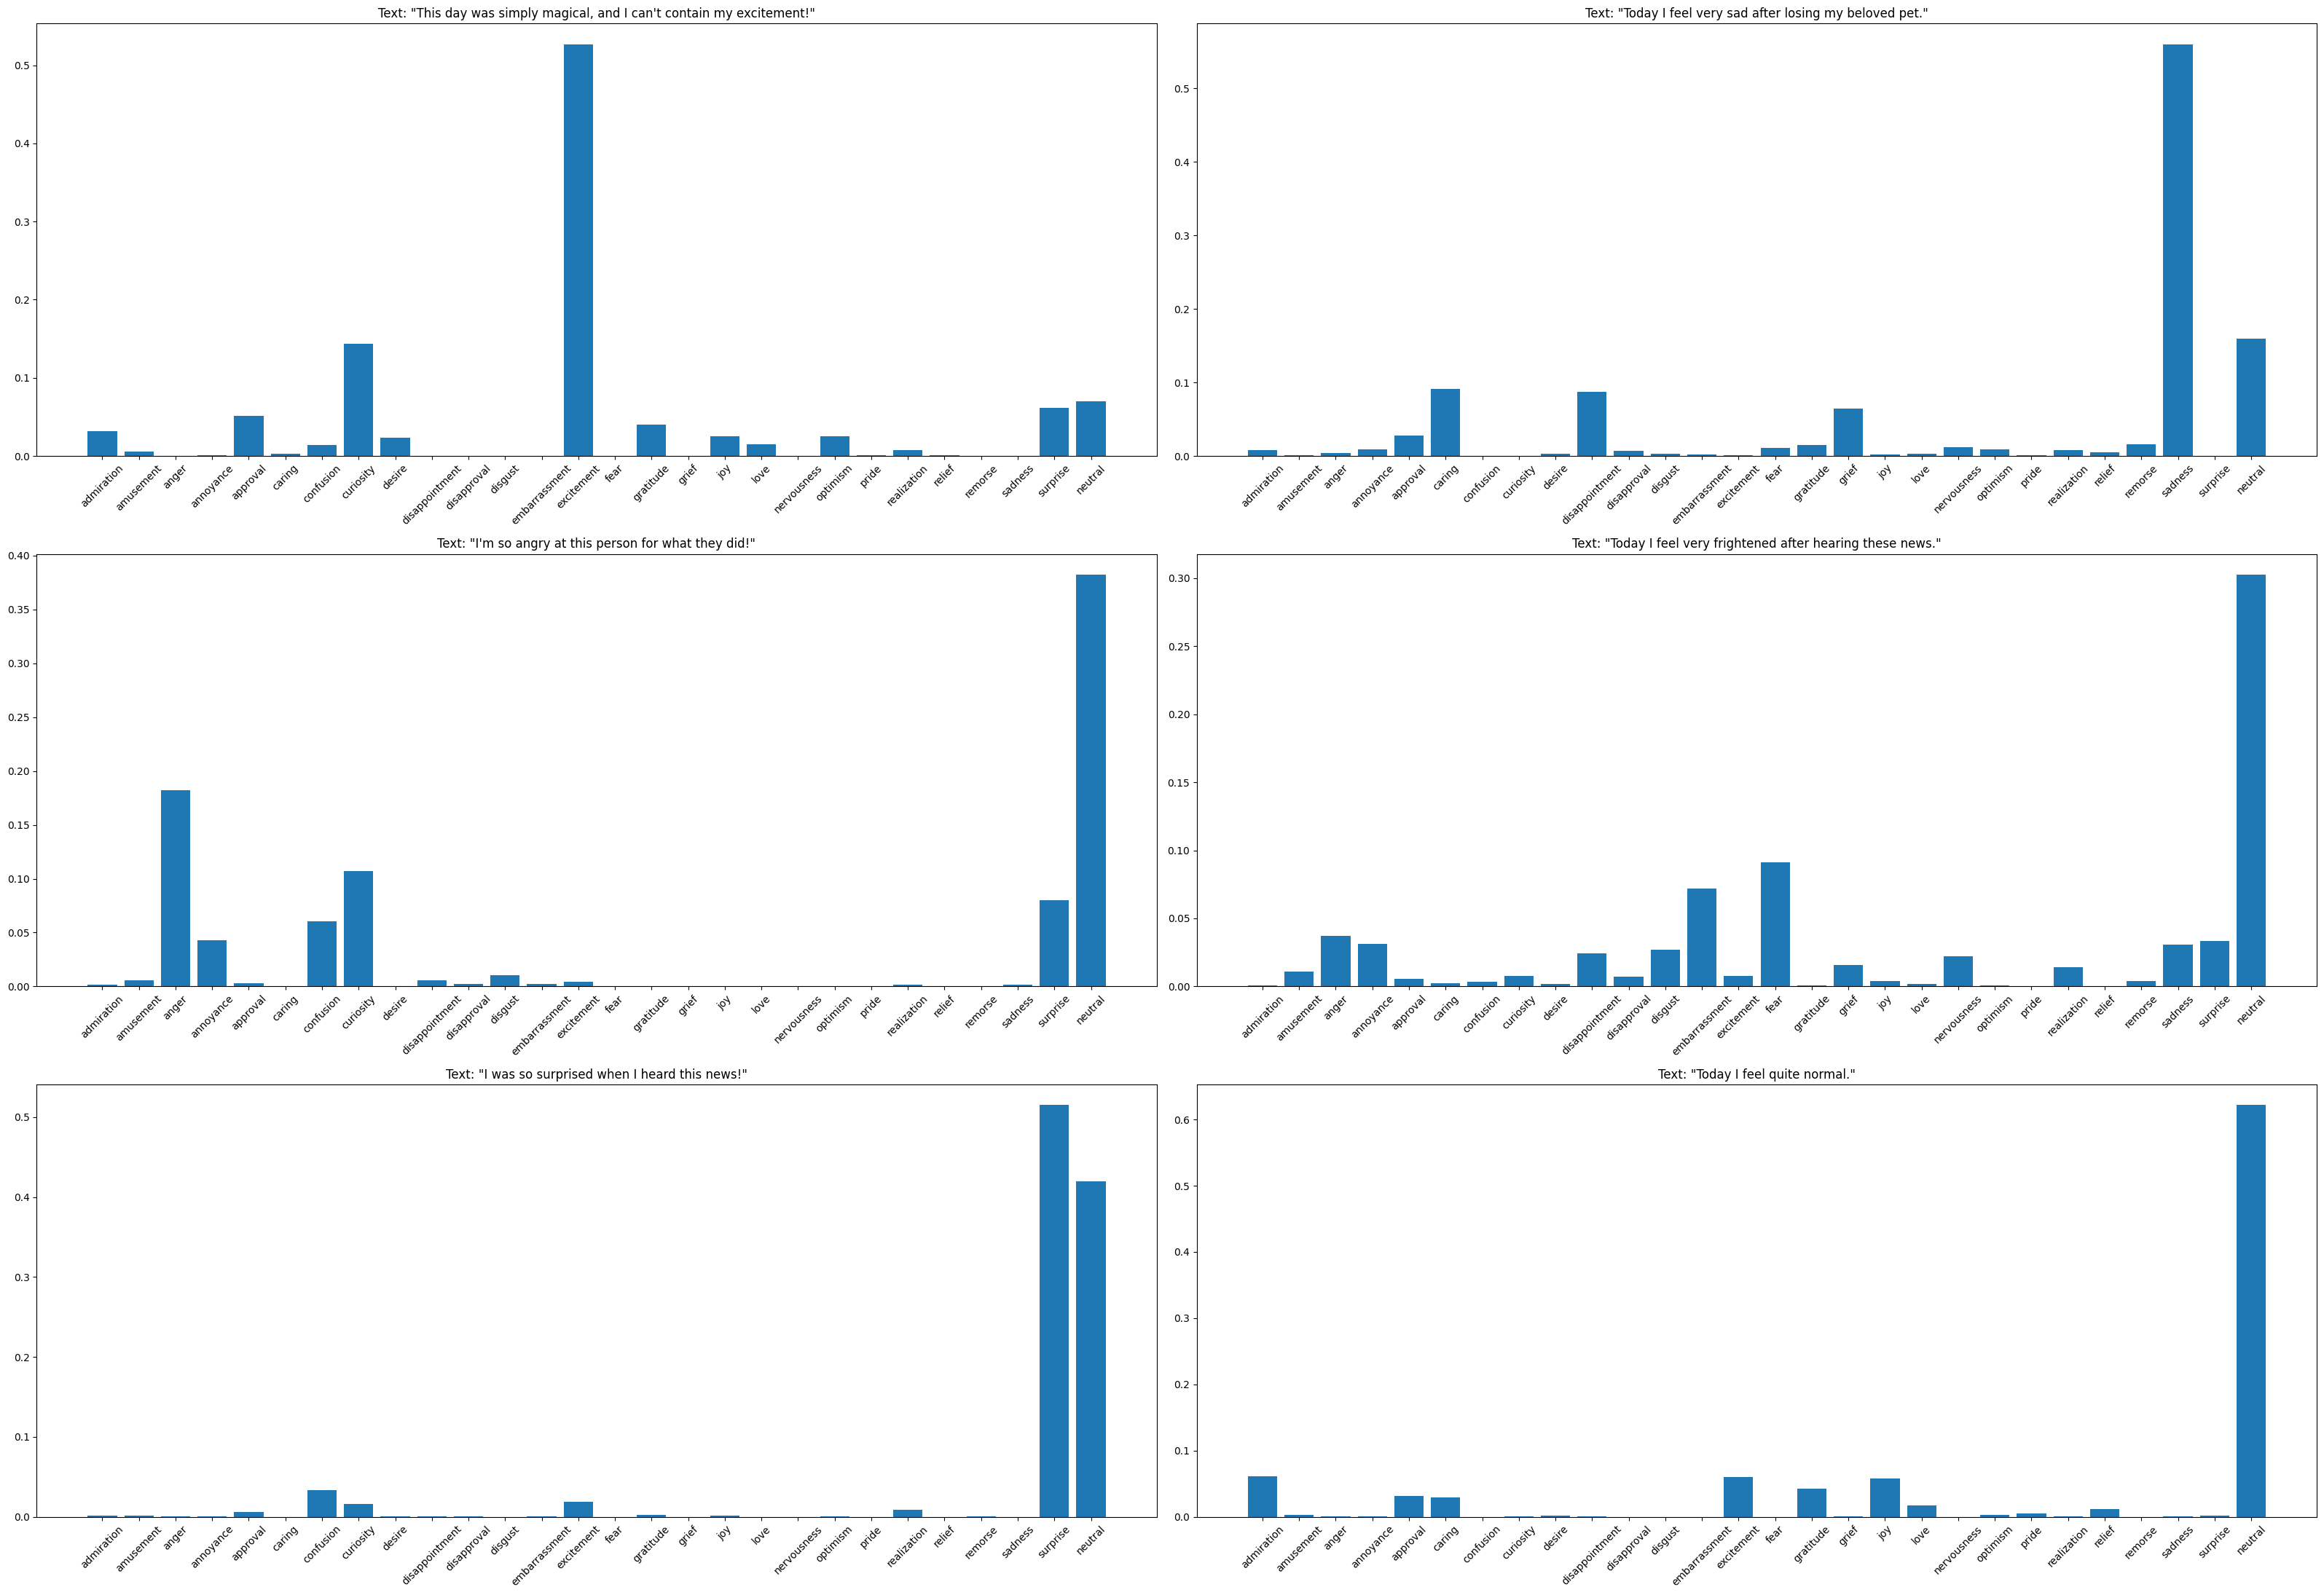

In [41]:
phrases_low = [
    "This day was simply magical, and I can't contain my excitement!", #"happiness"
    "Today I feel very sad after losing my beloved pet.", #"sadness"
    "I'm so angry at this person for what they did!", #"anger"
    "Today I feel very frightened after hearing these news.", #"fear"
    "I was so surprised when I heard this news!", #"surprise"
    "Today I feel quite normal.", #"neutral"
]

_, axes = plt.subplots(3, 2, figsize=(32, 22))

for i, text in enumerate(phrases_low):
    ax = axes[i // 2, i % 2]
    plot_emotion_scores(text, best_variable_model, max_length=None, ax=ax)
    
plt.tight_layout()
plt.show()

# Bonus

Train and evaluate the same model as your best one, but use a different cell type

In [42]:
bonus_model = get_model(
    units=128,
    n_tokens=tokenizer.vocab_size,
    n_labels=len(emotions),
    name='GRU_stacked',
    bidirectional=False,
    n_stacks=3,
    cell_type=tf.keras.layers.GRUCell
)
bonus_model.summary()

Model: "GRU_stacked"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ GRU_stacked_inputs (InputLayer) │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GRU_stacked_embedding           │ (None, None, 128)      │     6,432,896 │
│ (Embedding)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GRU_stacked_rnn (RNN)           │ (None, 128)            │       297,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GRU_stacked_dense (Dense)       │ (None, 28)             │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,733,724 (25.69 MB)

 Trainable params: 6,733,724 (25.69 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
bonus_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer=keras.optimizers.Adam(),
    metrics=[MeanRocAuc(num_classes=len(emotions)), MeanPRAuc(num_classes=len(emotions))]
)

In [47]:
print('Variable dataset')
print(f'model training: {bonus_model.name}')
history_bonus = bonus_model.fit(variable_train_dataset, validation_data=variable_test_dataset, batch_size=64, epochs=10)

Variable dataset
model training: GRU_stacked
Epoch 1/10


/home/dron46/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1730207553.185684  145787 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_99', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1730207553.334424  145778 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_99', 108 bytes spill stores, 108 bytes spill loads



2311/2311 ━━━━━━━━━━━━━━━━━━━━ 325s 135ms/step - loss: 0.1614 - mean_pr_auc: 0.0757 - mean_roc_auc: 0.5718 - val_loss: 0.1284 - val_mean_pr_auc: 0.2043 - val_mean_roc_auc: 0.7708
Epoch 2/10
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 35s 15ms/step - loss: 0.1237 - mean_pr_auc: 0.2306 - mean_roc_auc: 0.7999 - val_loss: 0.1195 - val_mean_pr_auc: 0.2729 - val_mean_roc_auc: 0.8301
Epoch 3/10
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 33s 14ms/step - loss: 0.1135 - mean_pr_auc: 0.3004 - mean_roc_auc: 0.8526 - val_loss: 0.1175 - val_mean_pr_auc: 0.2920 - val_mean_roc_auc: 0.8381
Epoch 4/10
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 35s 15ms/step - loss: 0.1073 - mean_pr_auc: 0.3455 - mean_roc_auc: 0.8773 - val_loss: 0.1176 - val_mean_pr_auc: 0.2993 - val_mean_roc_auc: 0.8401
Epoch 5/10
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 37s 16ms/step - loss: 0.1017 - mean_pr_auc: 0.3858 - mean_roc_auc: 0.8954 - val_loss: 0.1187 - val_mean_pr_auc: 0.2987 - val_mean_roc_auc: 0.8368
Epoch 6/10
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 37s 16ms/step - loss: 0.098

In [48]:
print('-'*30)
bonus_model.save_weights(f'new_wights/bonus_variable_{bonus_model.name}.weights.h5')
print(f'Веса модели {bonus_model.name} сохранены')

------------------------------
Веса модели GRU_stacked сохранены


In [100]:
print('-'*30)
bonus_model.load_weights(f'new_wights/bonus_variable_{bonus_model.name}.weights.h5')
print(f'Веса модели {bonus_model.name} загружены')

------------------------------
Веса модели GRU_bidirect_stacked загружены


/home/dron46/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 44 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


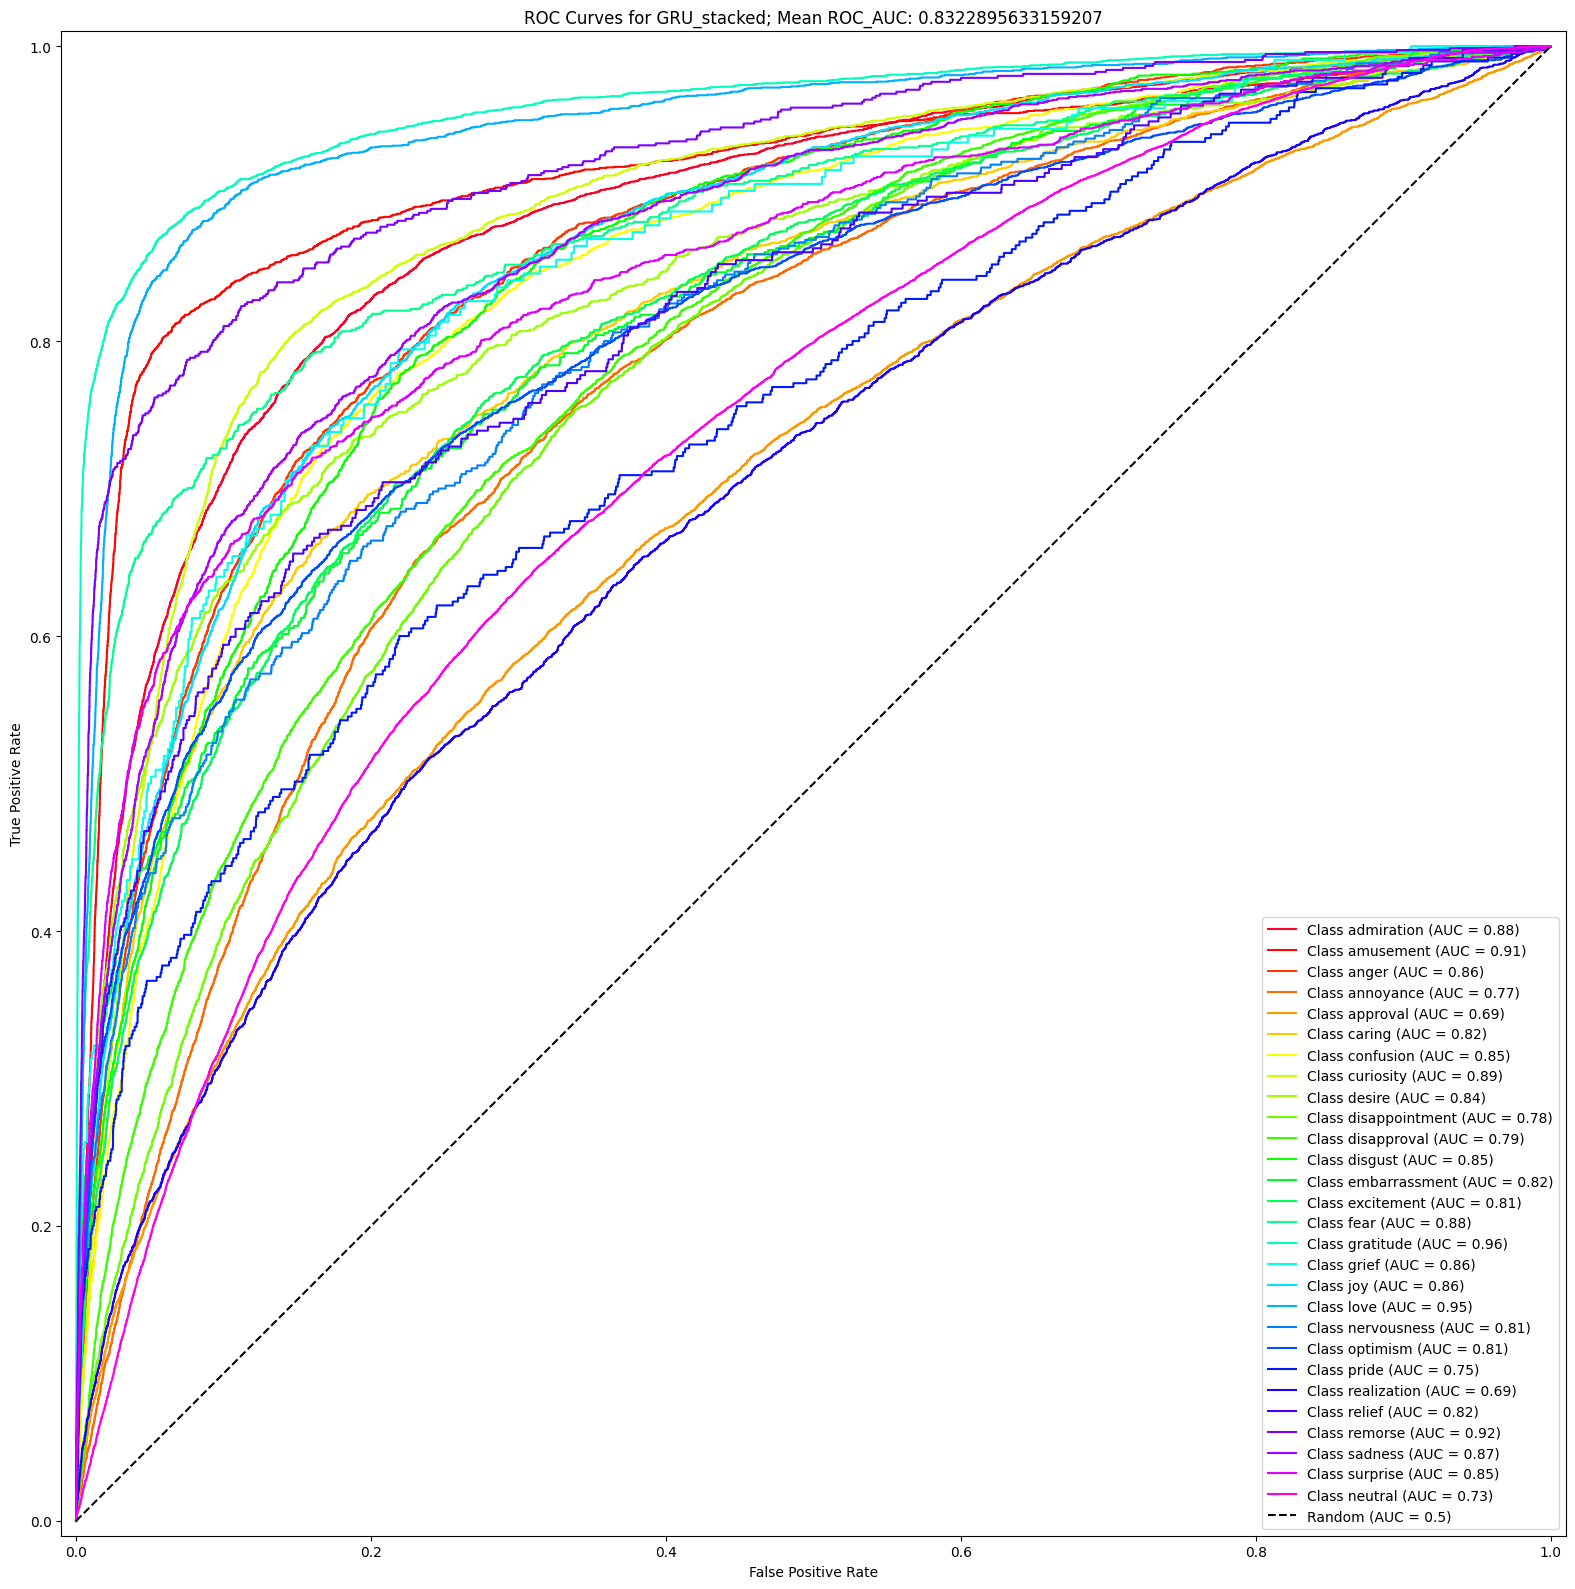

Среднее значение ROC_AUC для модели: GRU_stacked
83.229%


In [49]:
_, axes = plt.subplots(figsize=(24, 16))

mean_roc_auc_bonus = plot_roc_curves_2(variable_test_dataset, bonus_model, 28, bonus_model.name, ax=axes)

plt.tight_layout()
plt.show()

print(f"Среднее значение ROC_AUC для модели: {bonus_model.name}")
print(f'{np.round(mean_roc_auc_bonus, 5) * 100}%')

In [52]:
phrases = [
    "Today I feel incredibly happy!", #"happiness"
    "I'm so glad to finally see my family after a long absence.", #"happiness"
    "This day was simply magical, and I can't contain my excitement!", #"happiness"
    "Today I feel very sad after losing my beloved pet.", #"sadness"
    "It seems like the world is crashing down on me, and I don't know how to cope.", #"sadness"
    "This day was filled with sorrow and loneliness.", #"sadness"
    "I'm so angry at this person for what they did!", #"anger"
    "This is unfair, and I can't hold back my anger!", #"anger"
    "I feel like my blood is boiling when I think about this.", #"anger"
    "Today I feel very frightened after hearing these news.", #"fear"
    "It seems like the darkness around me is filled with horror.", #"fear"
    "I'm afraid that my fears are coming true, and I don't know how to deal with it.", #"fear"
    "I was so surprised when I heard this news!", #"surprise"
    "This twist of events left me stunned.", #"surprise"
    "I couldn't believe my eyes when I saw this!", #"surprise"
    "Today I feel quite normal.", #"neutral"
    "This day went by as usual, without any strong emotions.", #"neutral"
    "I'm just going about my business, not feeling anything special.", #"neutral"
]

In [53]:
len(phrases)

18

In [55]:
test_text = "I'm so angry at this person for what they did!"
print(test_text)
emothion_labels = label_text(test_text, bonus_model, threshold=0.4, max_length=None)
print(emothion_labels)
print()
test_text = "I feel like my blood is boiling when I think about this."
print(test_text)
emothion_labels = label_text(test_text, bonus_model, threshold=0.4, max_length=None)
print(emothion_labels)

I'm so angry at this person for what they did!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
['anger']

I feel like my blood is boiling when I think about this.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
['neutral']


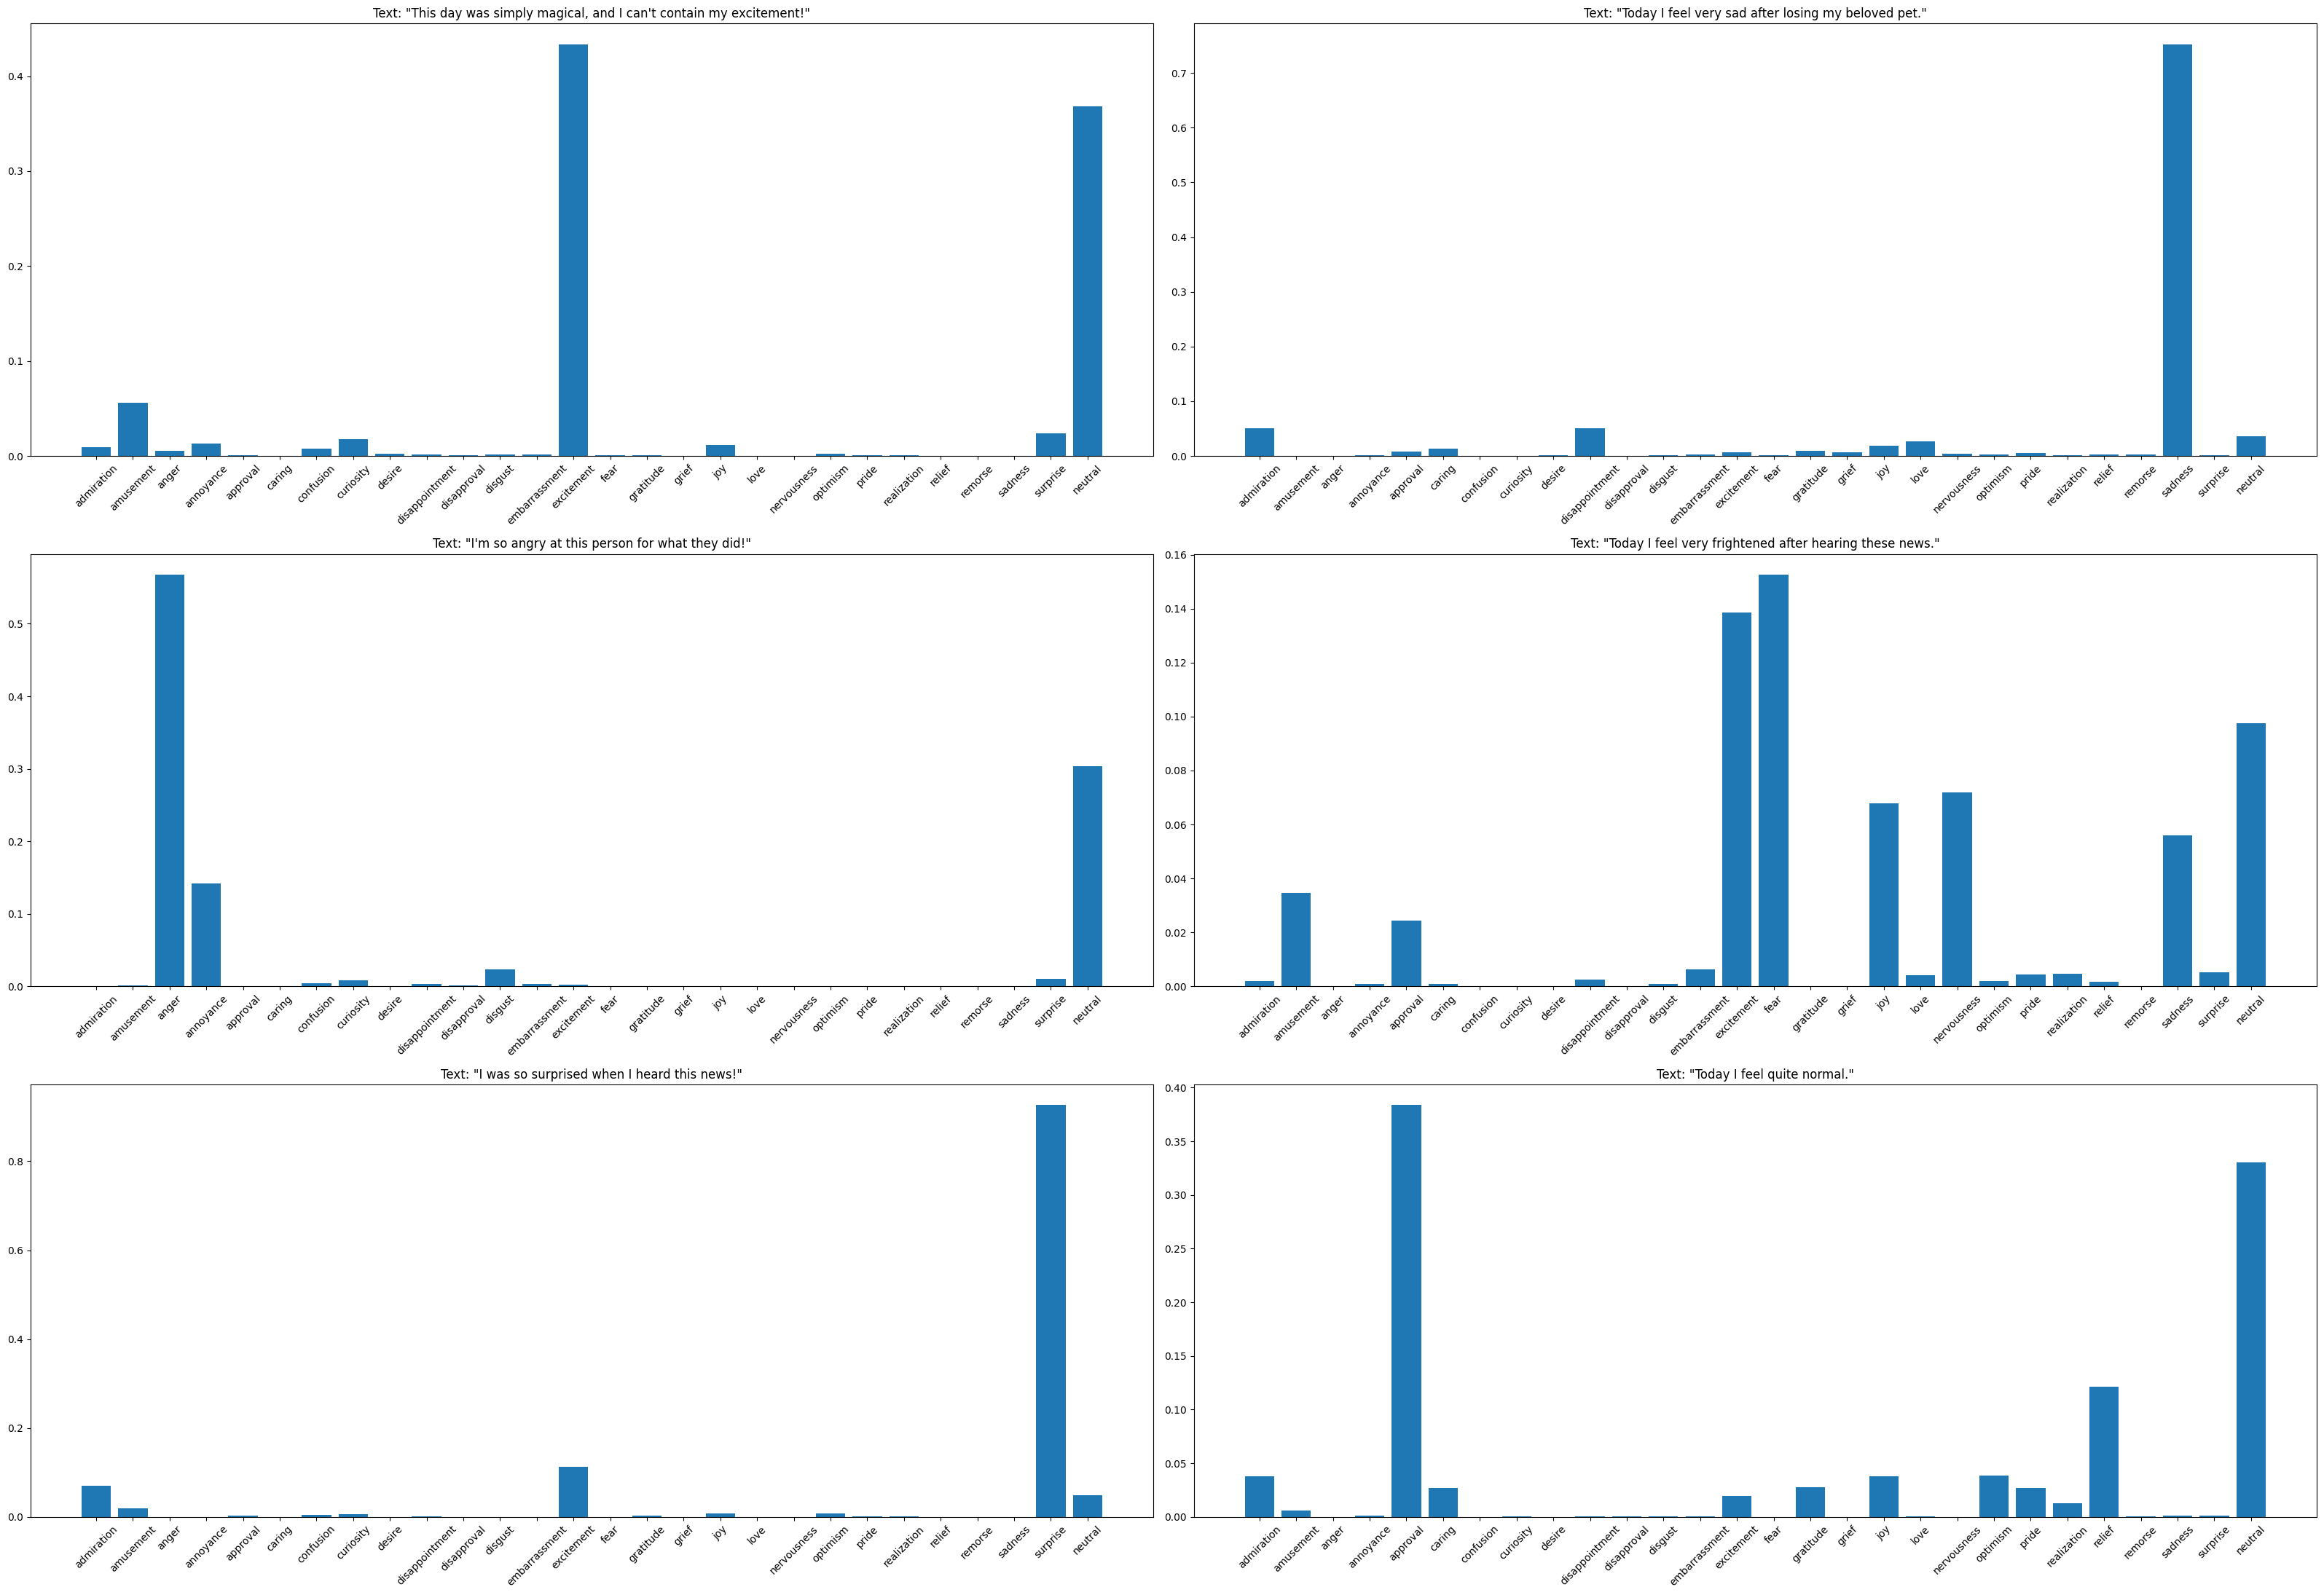

In [56]:
phrases_low = [
    "This day was simply magical, and I can't contain my excitement!", #"happiness"
    "Today I feel very sad after losing my beloved pet.", #"sadness"
    "I'm so angry at this person for what they did!", #"anger"
    "Today I feel very frightened after hearing these news.", #"fear"
    "I was so surprised when I heard this news!", #"surprise"
    "Today I feel quite normal.", #"neutral"
]

_, axes = plt.subplots(3, 2, figsize=(32, 22))

for i, text in enumerate(phrases_low):
    ax = axes[i // 2, i % 2]
    plot_emotion_scores(text, bonus_model, max_length=None, ax=ax)
    
plt.tight_layout()
plt.show()